# Extract Party Affiliation of every US Rep and Senator in 114th Congress

In [74]:
import re
import pandas as pd

# 114th Congress .txt file
with open('data/114th congress.txt', 'r', errors='ignore') as file:
    content = file.read()

# Split the reps on "Picture of"
parts = re.split(r'Picture of ', content)

# Initialize an empty list to store the data
Reps = []

# for loop over entire long list of reps
for part in parts:
    # Split on new line(\n) to separate the name from the title
    lines = part.split('\n')
    name = lines[0].strip()
    if len(lines) > 2:
        title = lines[2].strip()
        # The party is the first character after "U.S. Representative", "U.S. Representative (Former)", "Congressional Delegate", or "U.S. Senator"
        match = re.search(r'(U\.S\. Representative|U\.S\. Representative \(Former\)|Congressional Delegate|U\.S\. Senator)\s*([A-Z])-', title)
        if match:
            party = match.group(2)
            Reps.append([name, party])

# make dataframe of reps and affiliation
congress114 = pd.DataFrame(Reps, columns=['Name', 'Party'])

# Count the number of entries in the DataFrame
num_entries = len(congress114)

print(num_entries)
congress114.head(20)


547


,Name,Party
0,Ralph Abraham,R
1,Alma Adams,D
2,Robert T. Aderholt,R
3,Pete Aguilar,D
4,Rick Allen,R
5,Justin Amash,R
6,Mark Amodei,R
7,Brad Ashford,D
8,Brian Babin,R
9,Lou Barletta,R


## Looking at the info above, 547 seems to be the correct number-- 
there are 435 voting members in the U.S. House of Reps, 100 Senators, and an assortment of non-voting representatives (delegates) representing non-states (Washington D.C., American Samoa, Puerto Rico, etc.) 

congress114.to_csv('114th_Congress.csv') #write it to its own file

In [75]:
df = pd.read_csv('data/114th_Congress.csv')

In [76]:
# suffixes to be removed for merge
suffixes = ['Jr.', 'M.D.', 'II', 'IV', 'III', 'Sr.']

# Remove suffixes from names
for suffix in suffixes:
    df['Name'] = df['Name'].str.replace(f' {suffix}', '', regex=False)

df.head()

,Unnamed: 0,Name,Party
0,0,Ralph Abraham,R
1,1,Alma Adams,D
2,2,Robert T. Aderholt,R
3,3,Pete Aguilar,D
4,4,Rick Allen,R


In [77]:
df['Last Name'] = df['Name'].str.split().str[-1]
df_unique_last_names = df[~df['Last Name'].duplicated(keep=False)]
party_mapping_unique = df_unique_last_names.set_index('Last Name')['Party'].to_dict()

# Read and process 'political_social_media.csv'
cols_to_keep = ['bias','message','label','text']
political_tweets = pd.read_csv('data/political_social_media.csv', 
                                encoding='ISO-8859-1')
political_tweets = political_tweets[cols_to_keep]

# Extract the name from the 'label' column in 'political_social_media.csv'
political_tweets['Name'] = political_tweets['label'].str.extract(r'From: (.*?) \(', expand=False)
political_tweets['Last Name'] = political_tweets['Name'].str.split().str[-1]

# Merge the datasets
political_tweets['Party'] = political_tweets['Last Name'].map(party_mapping_unique)

# Drop NaNs from 'Party' column
political_tweets.dropna(subset=['Party'], inplace=True)

# Create the combined columns
political_tweets['Party_Bias'] = political_tweets['Party'] + '-' + political_tweets['bias']
political_tweets['Party_Message'] = political_tweets['Party'] + '-' + political_tweets['message']

# Display the first few rows of the merged DataFrame
political_tweets.head()



,bias,message,label,text,Name,Last Name,Party,Party_Bias,Party_Message
1,partisan,attack,From: Mitch McConnell (Senator from Kentucky),VIDEO - #Obamacare: Full of Higher Costs and ...,Mitch McConnell,McConnell,R,R-partisan,R-attack
2,neutral,support,From: Kurt Schrader (Representative from Oregon),Please join me today in remembering our fallen...,Kurt Schrader,Schrader,D,D-neutral,D-support
3,neutral,policy,From: Michael Crapo (Senator from Idaho),RT @SenatorLeahy: 1st step toward Senate debat...,Michael Crapo,Crapo,R,R-neutral,R-policy
4,partisan,policy,From: Mark Udall (Senator from Colorado),.@amazon delivery #drones show need to update ...,Mark Udall,Udall,D,D-partisan,D-policy
5,partisan,information,From: Heidi Heitkamp (Senator from North Dakota),Called on the @USDOTFRA to release info about ...,Heidi Heitkamp,Heitkamp,D,D-partisan,D-information


In [78]:
political_tweets.shape

(3946, 9)

political_tweets.to_csv('political_tweets.csv')

# Base Models Pipeline

In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split

# Generate a list of stopwords 
nltk.download('stopwords')
stops = stopwords.words('english') + list(string.punctuation)

# Read in data
df_partisan = pd.read_csv('political_tweets.csv')

# Convert string labels to 1 or 0 
le = LabelEncoder()
df_partisan['target'] = le.fit_transform(df_partisan['bias'])

# Examine our data
print(df_partisan.head())

# Separate features and labels 
X = df_partisan['text']
y = df_partisan['target']

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

   Unnamed: 0      bias      message  \
0           1  partisan       attack   
1           2   neutral      support   
2           3   neutral       policy   
3           4  partisan       policy   
4           5  partisan  information   

                                              label  \
0     From: Mitch McConnell (Senator from Kentucky)   
1  From: Kurt Schrader (Representative from Oregon)   
2          From: Michael Crapo (Senator from Idaho)   
3          From: Mark Udall (Senator from Colorado)   
4  From: Heidi Heitkamp (Senator from North Dakota)   

                                                text             Name  \
0  VIDEO - #Obamacare:  Full of Higher Costs and ...  Mitch McConnell   
1  Please join me today in remembering our fallen...    Kurt Schrader   
2  RT @SenatorLeahy: 1st step toward Senate debat...    Michael Crapo   
3  .@amazon delivery #drones show need to update ...       Mark Udall   
4  Called on the @USDOTFRA to release info about ...   Heidi He

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# Define the pipeline
pipeline = Pipeline([
    ('features', TfidfVectorizer(stop_words=stops)),
    ('classifier', RandomForestClassifier(random_state=1)),
])

# Define the parameter grid
param_grid = [
    {
        'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
        'classifier': [RandomForestClassifier(random_state=1)],
        'classifier__n_estimators': [4, 10, 100, 200, 500],
    },
    {
        'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 0.1, 1],
    },
    {
        'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
        'classifier': [SVC()],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10],
    },
]

# Define the grid search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

# Fit the grid search
grid.fit(X_train, y_train)

# Print the best estimator
print("Best estimator:")
print(grid.best_estimator_)

# Print the best score
print("Best F1 score:")
print(grid.best_score_)

# Print the best parameters
print("Best parameters:")
print(grid.best_params_)

# Get classification results on the test set
y_pred = grid.predict(X_test)
print("Classification report:")
print(classification_report(y_test, y_pred))



Best estimator:
Pipeline(steps=[('features',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', MultinomialNB(alpha=0.1))])
Best F1 score:
0.5113385165559079
Best parameters:
{'classifier': MultinomialNB(alpha=0.1), 'classifier__alpha': 0.1, 'features': CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", 

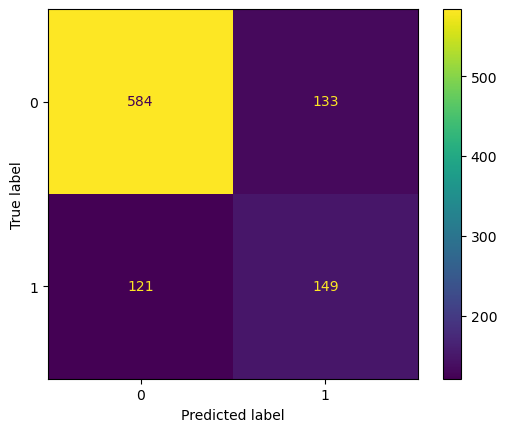

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [82]:
grid.best_estimator_.score(X_test, y_test)

0.7426545086119554

## Now With Some Preprocessing cleanup

In [83]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

In [84]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm



In [85]:
# anything with no of tokens <= 3 is likely junk. apply has additional args parameter to pass in function arguments.
df_partisan['text_cleaned'] = df_partisan['text'].apply(process_tweet, args = [3])

#our processing created some empty documents, so we should drop these.

In [86]:
# some documents are short enough cleaning may have wiped it out.
df_partisan_new = df_partisan[df_partisan['text_cleaned'] != '']

In [87]:
df_partisan_new.shape

(3778, 12)

In [88]:
X_new= df_partisan_new['text_cleaned']
y_new= df_partisan_new['target']

In [89]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.25, random_state=1)

## The best estimator for scoring on ROC-AUC

# Print the best estimator
print("Best estimator:")
print(grid.best_estimator_)

# Print the best score
print("Best AUC-ROC score:")
print(grid.best_score_)

# Print the best parameters
print("Best parameters:")
print(grid.best_params_)

# Get classification results on the test set
y_pred_new = grid.predict(X_test_new)
print("Classification report:")
print(classification_report(y_test_new, y_pred_new))
ConfusionMatrixDisplay.from_predictions(y_test_new, y_pred_new)


              precision    recall  f1-score   support

           0       0.87      0.84      0.85       697
           1       0.58      0.64      0.61       248

    accuracy                           0.79       945
   macro avg       0.72      0.74      0.73       945
weighted avg       0.79      0.79      0.79       945



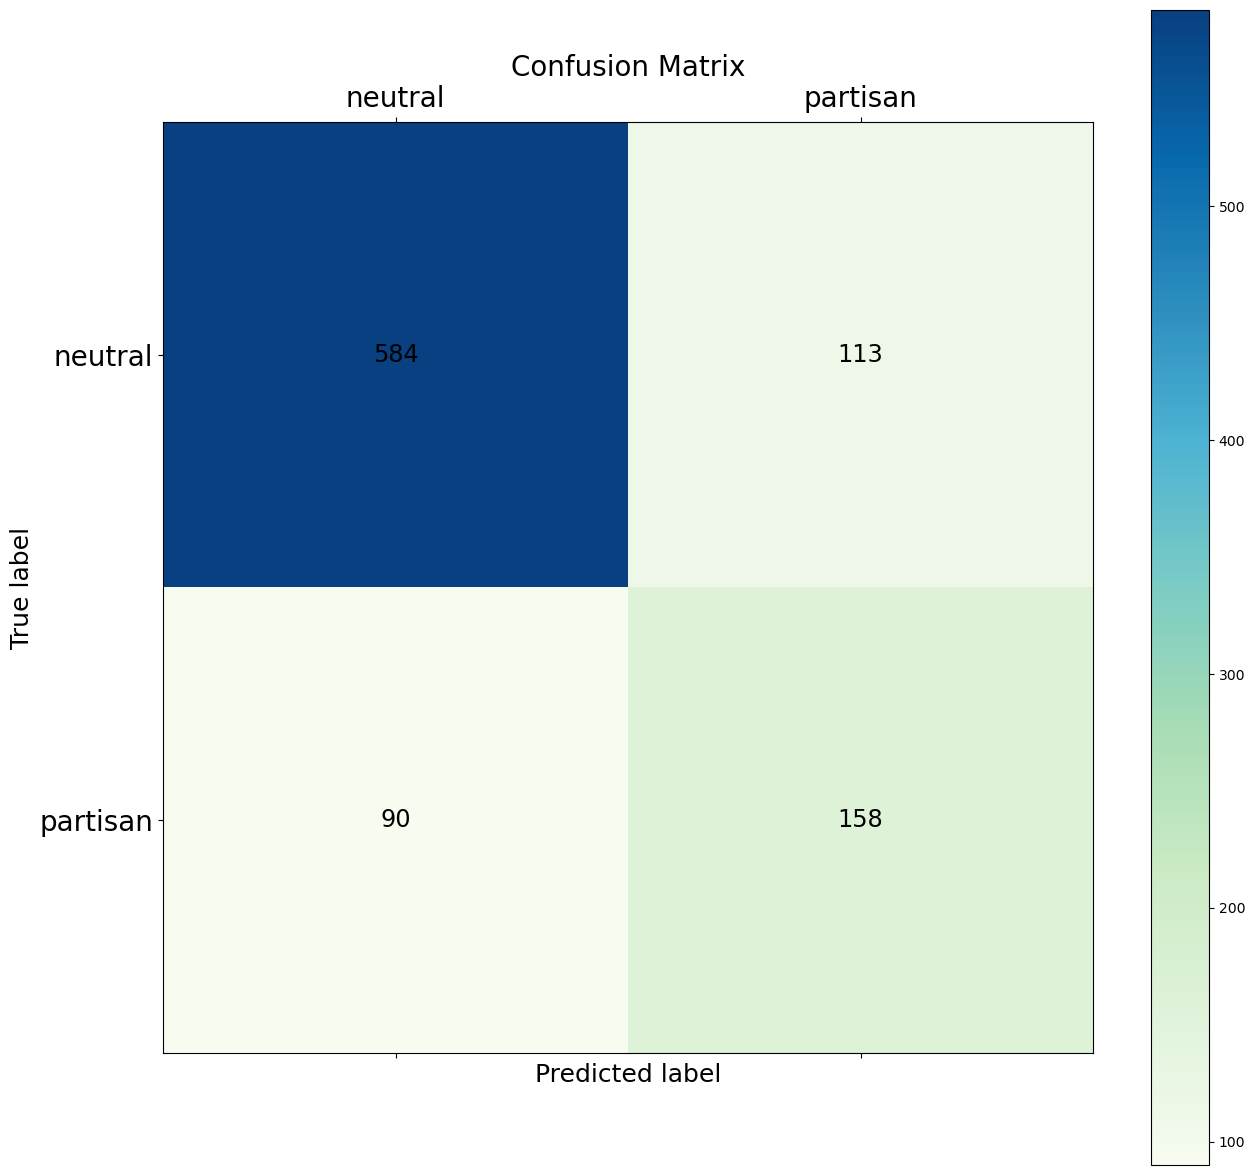

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

stop_words = stopwords.words('english')

pipeline = Pipeline([
    ('features', CountVectorizer(stop_words=stop_words)),
    ('classifier', MultinomialNB(alpha=0.1)),
])

# now you can fit and predict with this pipeline
pipeline.fit(X_train_new, y_train_new)
predictions = pipeline.predict(X_test_new)
# Get classification results on the test set


print(classification_report(y_test_new, y_pred_new))

y_test_new_labels = le.inverse_transform(y_test_new)
y_pred_new_labels = le.inverse_transform(y_pred_new)
cm = confusion_matrix(y_test_new_labels, y_pred_new_labels)

fig, ax = plt.subplots(figsize=(15, 15))
cax = ax.matshow(cm, cmap=plt.cm.GnBu)

fig.colorbar(cax)


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

# Get labels
class_names = le.classes_

# Set x-tick labels
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, fontsize=20)

# Set y-tick labels
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, fontsize=20)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

plt.show()

## Best estimator for scoring on F1

Best estimator:
Pipeline(steps=[('features',
                 CountVectorizer(max_df=0.25, min_df=5,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('classifier', MultinomialNB(alpha=1))])
Best F1 score:
0.5370035190344506
Best parameters:
{'classifier': MultinomialNB(alpha=1), 'classifier__alpha': 1, 'features': CountVectorizer(max_df=0.25, min_df=5,
                stop_words=['i', 'me', 'my', 'myself', 

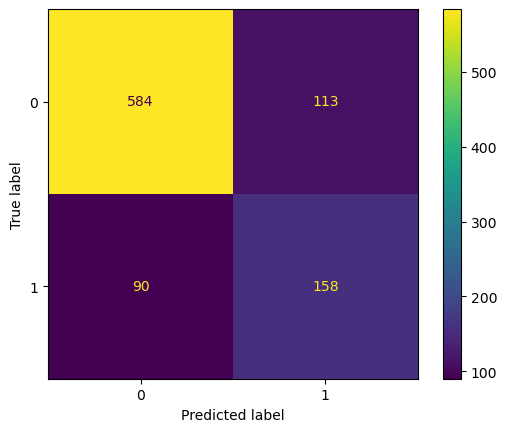

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline
pipeline = Pipeline([
    ('features', TfidfVectorizer(stop_words=stops)),
    ('classifier', RandomForestClassifier(random_state=1)),
])

# Define the parameter grid
param_grid = [
    {
        'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
        'features__ngram_range': [(1, 1), (1, 2)],
        'features__min_df': [5, 10],
        'features__max_df': [0.1, 0.25, 0.5],
        'classifier': [RandomForestClassifier(random_state=1)],
        'classifier__n_estimators': [100, 200],
    },
    {
        'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
        'features__ngram_range': [(1, 1), (1, 2)],
        'features__min_df': [5, 10, 20],
        'features__max_df': [0.1, 0.25, 0.5],
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.5, 1],
    },
#     {
#         'features': [TfidfVectorizer(stop_words=stops), CountVectorizer(stop_words=stops)],
#         'features__ngram_range': [(1, 1), (1, 2)],
#         'features__min_df': [1, 5, 10],
#         'features__max_df': [0.5, 0.75, 1.0],
#         'classifier': [SVC()],
#         'classifier__kernel': ['linear', 'rbf'],
#         'classifier__C': [0.1, 1, 10],
#     },
]

# Define the grid search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

# Fit the grid search
grid.fit(X_train_new, y_train_new)


# Print the best estimator
print("Best estimator:")
print(grid.best_estimator_)

# Print the best score
print("Best F1 score:")
print(grid.best_score_)

# Print the best parameters
print("Best parameters:")
print(grid.best_params_)

# Get classification results on the test set
y_pred_new = grid.predict(X_test_new)
print("Classification report:")
print(classification_report(y_test_new, y_pred_new))
ConfusionMatrixDisplay.from_predictions(y_test_new, y_pred_new)


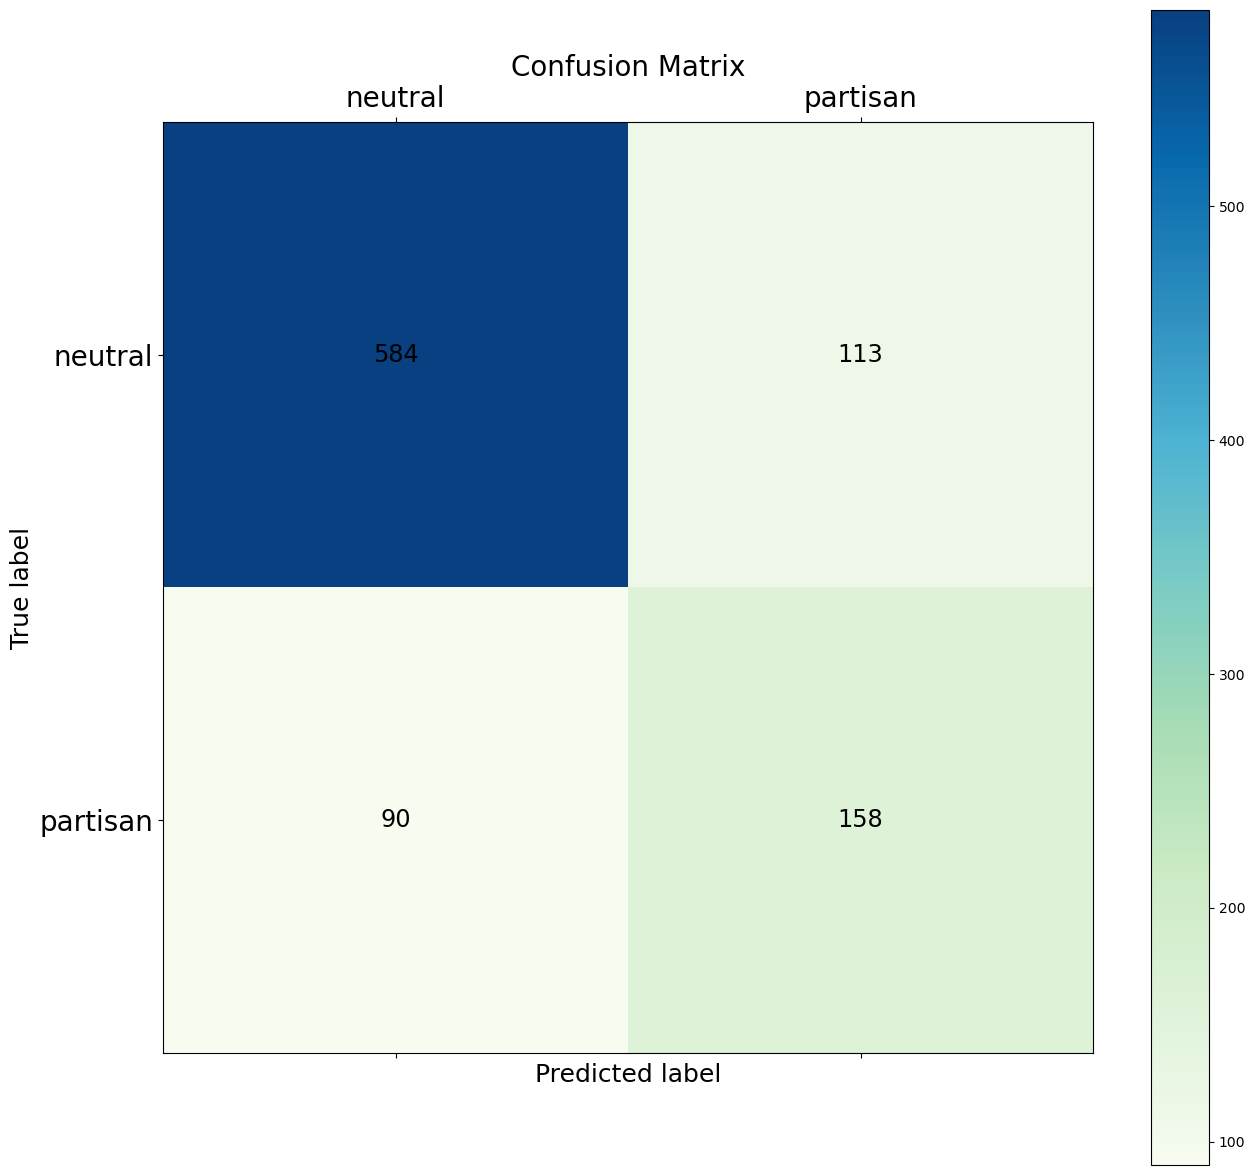

In [92]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_test_new_labels = le.inverse_transform(y_test_new)
y_pred_new_labels = le.inverse_transform(y_pred_new)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_new_labels, y_pred_new_labels)

fig, ax = plt.subplots(figsize=(15, 15))

# Display the confusion matrix
cax = ax.matshow(cm, cmap=plt.cm.GnBu)

fig.colorbar(cax)

# Add text annotations to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

# Get the class names
class_names = le.classes_

# Set x-tick labels
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, fontsize=20)

# Set y-tick labels
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, fontsize=20)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)

plt.show()


# BIAS-- Now Incorporating Word2Vec and cleanup steps

In [38]:
import gensim
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

/var/folders/bf/n_rprvk91ndgxz_bd75lz03h0000gp/T/ipykernel_20041/3748145976.py:4: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  wv.init_sims(replace=True)


In [94]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [96]:
import logging
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df_partisan_new, test_size=0.25, random_state = 1)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text_cleaned']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text_cleaned']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

# Best GNB (Best_GNB_Bias)

accuracy 0.746031746031746
              precision    recall  f1-score   support

     neutral       0.89      0.75      0.81       697
    partisan       0.51      0.74      0.60       248

    accuracy                           0.75       945
   macro avg       0.70      0.74      0.71       945
weighted avg       0.79      0.75      0.76       945



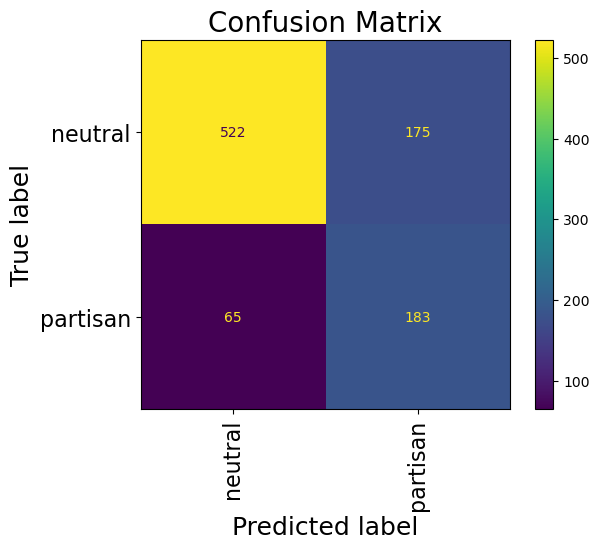

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

Best_GNB_bias = GaussianNB()
Best_GNB_bias = Best_GNB_bias.fit(X_train_word_average, train['bias'])
y_pred = Best_GNB_bias.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.bias))
print(classification_report(test.bias, y_pred))
ConfusionMatrixDisplay.from_predictions(test.bias, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy 0.7457337883959044
              precision    recall  f1-score   support

     neutral       0.81      0.86      0.83       869
    partisan       0.51      0.43      0.46       303

    accuracy                           0.75      1172
   macro avg       0.66      0.64      0.65      1172
weighted avg       0.73      0.75      0.74      1172



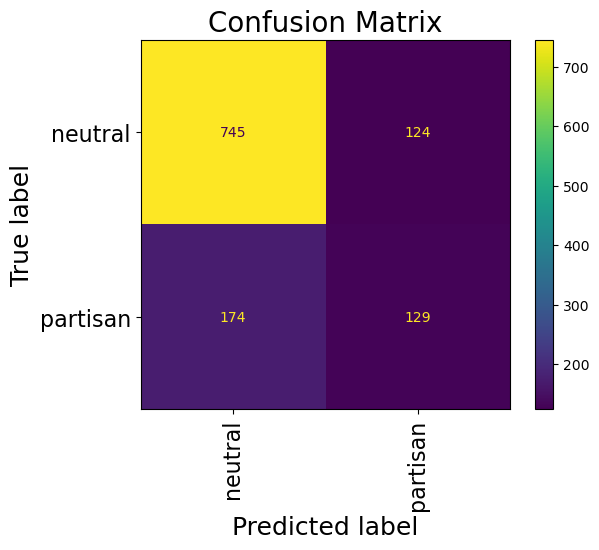

In [115]:
from sklearn.neural_network import MLPClassifier

Best_NN_bias = MLPClassifier()
Best_NN_bias = NN_clf.fit(X_train_word_average, train['bias'])
y_pred = NN_clf.predict(X_test_word_average)


print('accuracy %s' % accuracy_score(y_pred, test.bias))
print(classification_report(test.bias, y_pred))
ConfusionMatrixDisplay.from_predictions(test.bias, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()


# PARTY-BIAS (with W2V)

accuracy 0.40429887410440124
              precision    recall  f1-score   support

   D-neutral       0.47      0.35      0.40       310
  D-partisan       0.17      0.47      0.24        98
   R-neutral       0.58      0.45      0.51       419
  R-partisan       0.36      0.34      0.35       150

    accuracy                           0.40       977
   macro avg       0.39      0.40      0.38       977
weighted avg       0.47      0.40      0.42       977



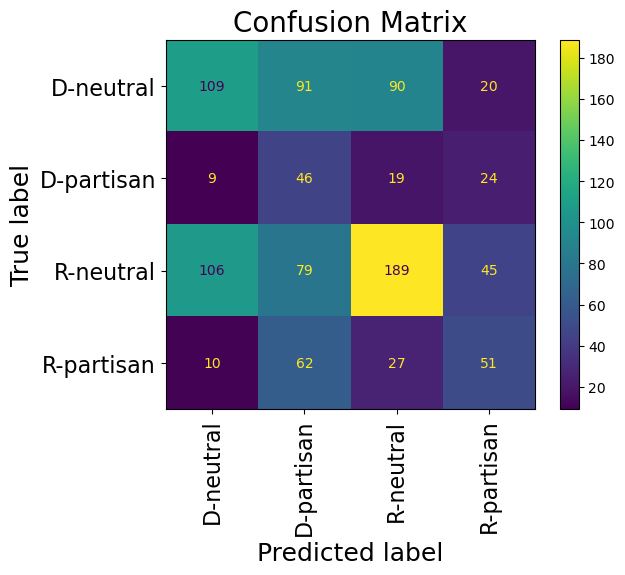

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

Best_GNB_PB = GaussianNB()
Best_GNB_PB = Best_GNB_PB.fit(X_train_word_average, train['Party_Bias'])
y_pred = Best_GNB_PB.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Party_Bias))
print(classification_report(test.Party_Bias, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party_Bias, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the pipeline
pipeline = Pipeline([
    ('features', CountVectorizer(max_df=0.25, min_df=5, 
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
    ('classifier', MultinomialNB(alpha=1))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict the test data
y_pred = pipeline.predict(X_test)


# Party Best_GNB

accuracy 0.5714285714285714
              precision    recall  f1-score   support

           D       0.51      0.57      0.54       406
           I       0.36      0.56      0.43         9
           R       0.64      0.57      0.60       530

    accuracy                           0.57       945
   macro avg       0.50      0.57      0.53       945
weighted avg       0.58      0.57      0.57       945



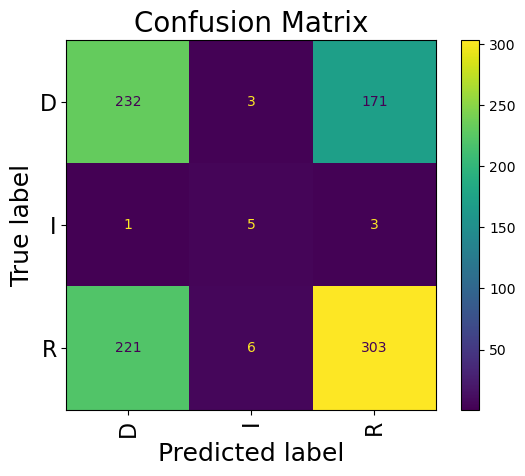

In [98]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

Best_GNB_PB = GaussianNB()
Best_GNB_PB = Best_GNB_PB.fit(X_train_word_average, train['Party'])
y_pred = Best_GNB_PB.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

# Predicting on new targets (eventually incorporating word2vec)-- Party Bias, and Party Message (BASE MODELS)

              precision    recall  f1-score   support

           0       0.52      0.38      0.44       385
           1       0.67      0.07      0.13       108
           2       0.48      0.80      0.60       484
           3       0.62      0.25      0.35       195

    accuracy                           0.50      1172
   macro avg       0.57      0.37      0.38      1172
weighted avg       0.53      0.50      0.46      1172

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00         8
           6       0.28      0.18      0.22       131
           7       0.34      0.24      0.28       132
           8       0.13      0.02      0.03       107
           9       0.00 

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

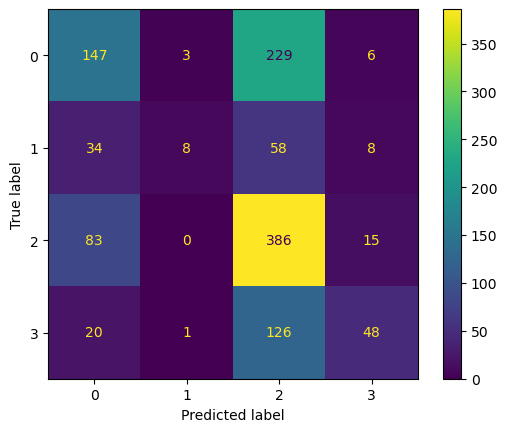

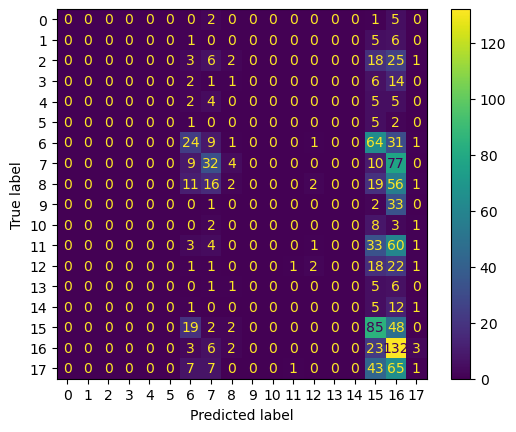

In [87]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your data
df = pd.read_csv('political_tweets.csv')
df = df[df['Party'] != 'I']

# Define your features and targets
X = df['text']
y_pbias = df['Party_Bias']
y_pmessage = df['Party_Message']

# Encode your targets
le_pbias = LabelEncoder()
le_pmessage = LabelEncoder()
y_pbias = le_bias.fit_transform(y_pbias)
y_pmessage = le_message.fit_transform(y_pmessage)

# Split your data
X_train, X_test, y_train_pbias, y_test_pbias = train_test_split(X, y_pbias, test_size=0.3, random_state=42)
X_train, X_test, y_train_pmessage, y_test_pmessage = train_test_split(X, y_pmessage, test_size=0.3, random_state=42)

# Define your pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2),stop_words=stops)),
    ('clf', MultinomialNB(alpha=1)),
])


# Train your classifier for Party_Bias
pipeline.fit(X_train, y_train_pbias)
y_pred_pbias = pipeline.predict(X_test)
print(classification_report(y_test_pbias, y_pred_pbias))
ConfusionMatrixDisplay.from_predictions(y_test_pbias, y_pred_pbias)

# Train your classifier for Party_Message
pipeline.fit(X_train, y_train_pmessage)
y_pred_pmessage = pipeline.predict(X_test)
print(classification_report(y_test_pmessage, y_pred_pmessage))
ConfusionMatrixDisplay.from_predictions(y_test_pmessage, y_pred_pmessage)

              precision    recall  f1-score   support

   D-neutral       0.52      0.38      0.44       385
  D-partisan       0.67      0.07      0.13       108
   R-neutral       0.48      0.80      0.60       484
  R-partisan       0.62      0.25      0.35       195

    accuracy                           0.50      1172
   macro avg       0.57      0.37      0.38      1172
weighted avg       0.53      0.50      0.46      1172



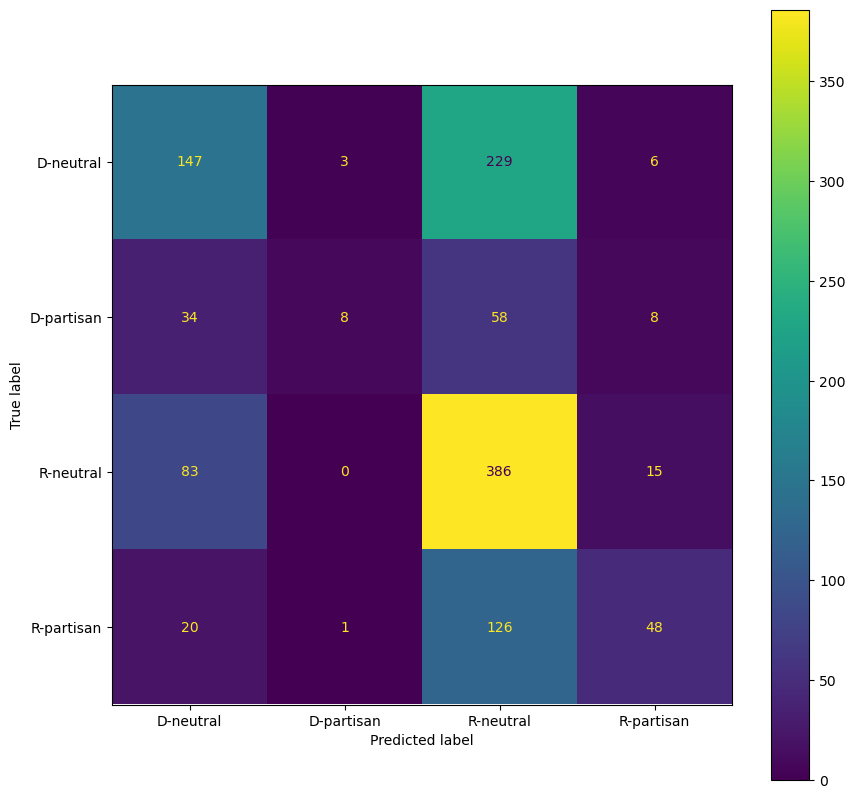

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train classifier on Party_Bias
pipeline.fit(X_train, y_train_pbias)
y_pred_pbias = pipeline.predict(X_test)

# Inverse transform predictions
y_test_pbias_labels = le_bias.inverse_transform(y_test_pbias)
y_pred_pbias_labels = le_bias.inverse_transform(y_pred_pbias)

print(classification_report(y_test_pbias_labels, y_pred_pbias_labels))

# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 10)) # adjust the size of the figure
ConfusionMatrixDisplay.from_predictions(y_test_pbias_labels, y_pred_pbias_labels, ax=ax)

/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

                precision    recall  f1-score   support

      D-attack       0.00      0.00      0.00         8
D-constituency       0.00      0.00      0.00        12
 D-information       0.00      0.00      0.00        55
       D-media       0.00      0.00      0.00        24
D-mobilization       0.00      0.00      0.00        16
       D-other       0.00      0.00      0.00         8
    D-personal       0.28      0.18      0.22       131
      D-policy       0.34      0.24      0.28       132
     D-support       0.13      0.02      0.03       107
      R-attack       0.00      0.00      0.00        36
R-constituency       0.00      0.00      0.00        14
 R-information       0.00      0.00      0.00       102
       R-media       0.33      0.04      0.08        46
R-mobilization       0.00      0.00      0.00        13
       R-other       0.00      0.00      0.00        19
    R-personal       0.24      0.54      0.33       156
      R-policy       0.22      0.78      0.34  

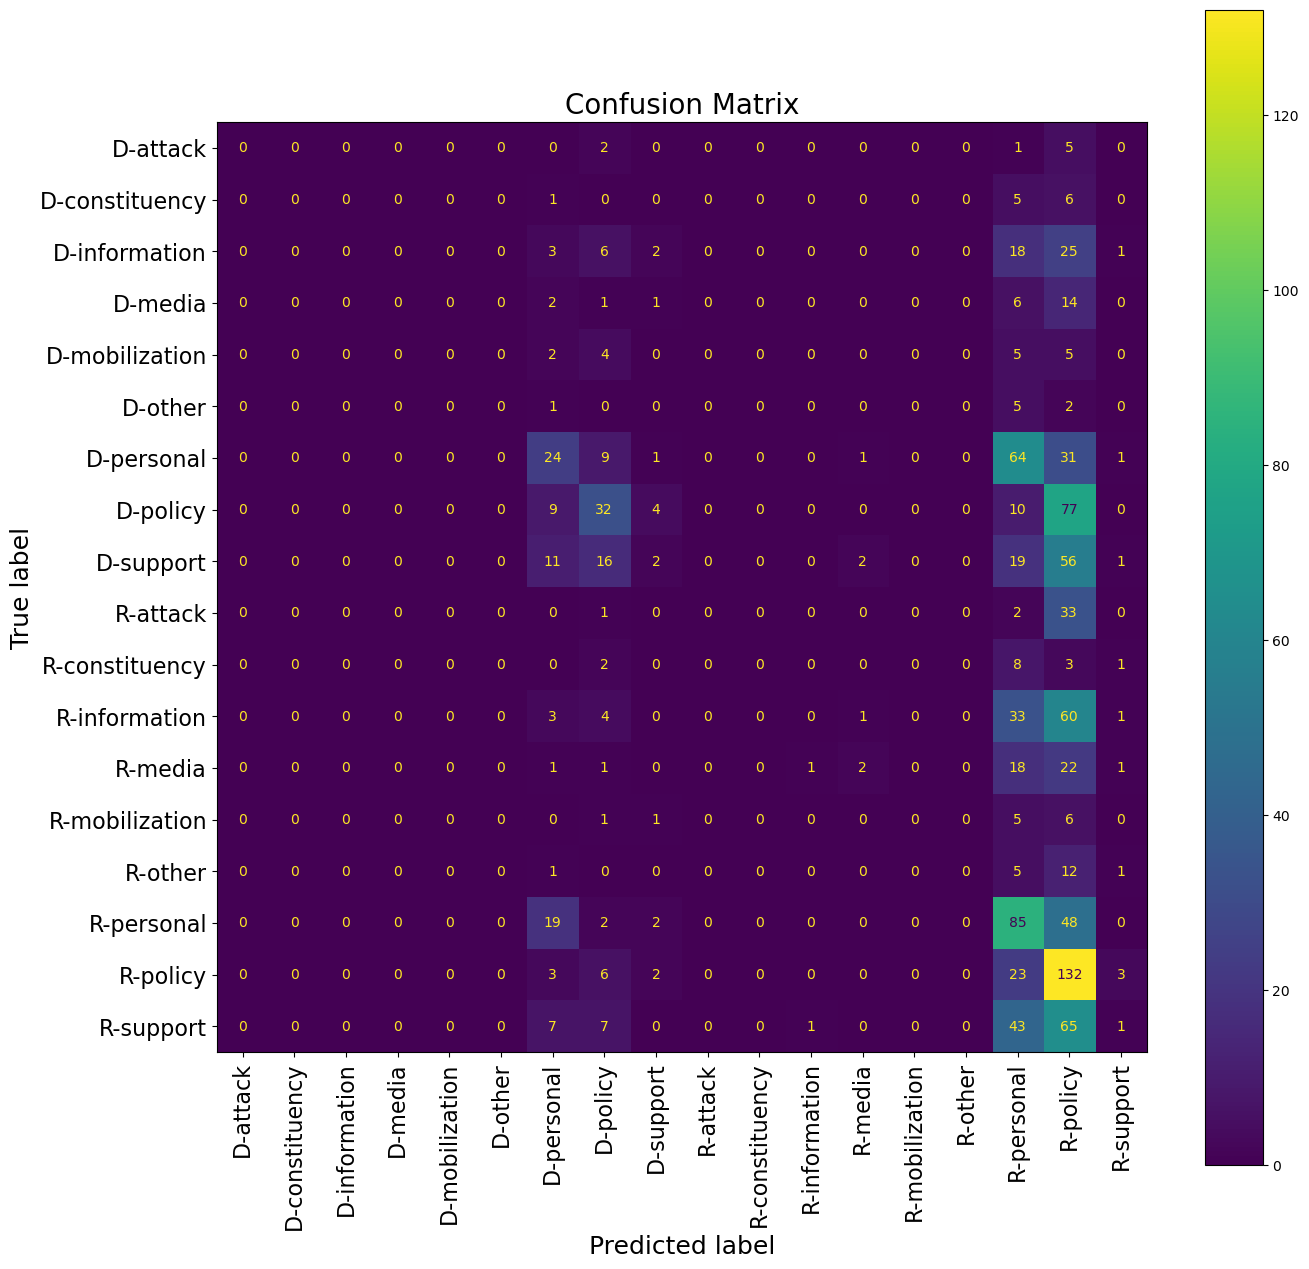

In [90]:
# Inverse transform predictions
y_test_pmessage_labels = le_message.inverse_transform(y_test_pmessage)
y_pred_pmessage_labels = le_message.inverse_transform(y_pred_pmessage)

print(classification_report(y_test_pmessage_labels, y_pred_pmessage_labels))

# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))  # increase figure size
ConfusionMatrixDisplay.from_predictions(y_test_pmessage_labels, y_pred_pmessage_labels, ax=ax)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

# Incorporating word2vec

In [ ]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

## Now just predict on message, regardless of party

In [8]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df_poli = pd.read_csv('data/political_tweets.csv')
print(df_poli.head(10))

   Unnamed: 0      bias      message  \
0           1  partisan       attack   
1           2   neutral      support   
2           3   neutral       policy   
3           4  partisan       policy   
4           5  partisan  information   
5           8   neutral     personal   
6           9  partisan      support   
7          10  partisan       policy   
8          11  partisan       attack   
9          12   neutral       policy   

                                               label  \
0      From: Mitch McConnell (Senator from Kentucky)   
1   From: Kurt Schrader (Representative from Oregon)   
2           From: Michael Crapo (Senator from Idaho)   
3           From: Mark Udall (Senator from Colorado)   
4   From: Heidi Heitkamp (Senator from North Dakota)   
5  From: Chuck Fleischmann (Representative from T...   
6   From: Steny Hoyer (Representative from Maryland)   
7  From: John Fleming (Representative from Louisi...   
8  From: Adam Kinzinger (Representative from Illi...   

In [9]:
from nltk.corpus import stopwords

replace_w_space = re.compile('[/(){}\[\]\|,;]')#I took out the @ symbol but maybe I should add it back
bad_symbols_re = re.compile('[^0-9a-z @#+_]')
stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = replace_w_space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = bad_symbols_re.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwors from text
    return text
    
df_poli['text'] = df_poli['text'].apply(clean_text)
df_poli['text'].head(20)

0     video #obamacare full higher costs broken prom...
1     please join today remembering fallen heroes ho...
2     rt @senatorleahy 1st step toward senate debate...
3     @amazon delivery #drones show need update law ...
4     called @usdotfra release info inspections #cas...
5     wonderful night state senator ken yagers chili...
6     great oped pres clinton signing #fmla 20 yrs a...
7     potus golfs pushes amnesty amp ignores keyston...
8     president doesnt get decide doesnt like congre...
9     fact recovery act cut taxes middleclass famili...
10    rt @mha telemedicine consults rural ers helps ...
11             @skitchp wouldnt wish anyone even skitch
12    545pm sen @corybooker give maiden senate speec...
13    come liberation bound mine let us work togethe...
14    health coverage starting jan 1st must sign @ac...
15    tks margaret 4 joining dc share successes nisk...
16    great look back idaho native american tribes 1...
17    #otd 1969 american astronaut neil armstron

In [10]:
X = df_poli['text']
y_message = df_poli['message']
# X = X.dropna()
# y_message = y[X.index]  # Ensure y matches X
X_train, X_test, y_train_message, y_test_message = train_test_split(X, y_message, test_size=0.2, random_state = 42)

# Base Message

accuracy 0.41139240506329117
              precision    recall  f1-score   support

      attack       0.00      0.00      0.00        19
constituency       0.00      0.00      0.00        23
 information       0.00      0.00      0.00       119
       media       0.00      0.00      0.00        49
mobilization       0.00      0.00      0.00        22
       other       0.00      0.00      0.00        26
    personal       0.43      0.66      0.52       182
      policy       0.40      0.92      0.56       222
     support       0.33      0.01      0.02       128

    accuracy                           0.41       790
   macro avg       0.13      0.18      0.12       790
weighted avg       0.27      0.41      0.28       790



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

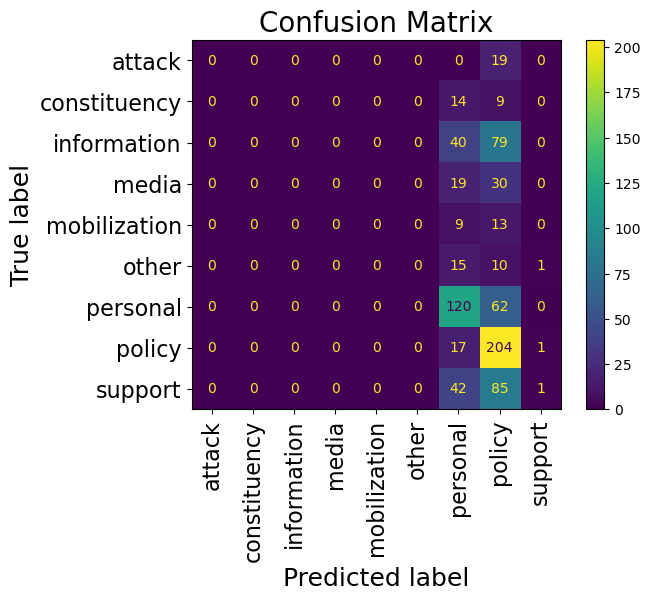

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import ConfusionMatrixDisplay

nb_clf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb_clf.fit(X_train, y_train_message)

# %%time
from sklearn.metrics import classification_report
y_pred = nb_clf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test_message))
print(classification_report(y_test_message, y_pred))
# fig, ax = plt.subplots(figsize=(15, 15))  # increase figure size
ConfusionMatrixDisplay.from_predictions(y_test_message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

accuracy 0.3987341772151899
              precision    recall  f1-score   support

      attack       0.14      0.05      0.08        19
constituency       0.17      0.04      0.07        23
 information       0.25      0.12      0.16       119
       media       0.54      0.27      0.36        49
mobilization       0.00      0.00      0.00        22
       other       0.00      0.00      0.00        26
    personal       0.42      0.62      0.50       182
      policy       0.45      0.69      0.55       222
     support       0.25      0.16      0.20       128

    accuracy                           0.40       790
   macro avg       0.25      0.22      0.21       790
weighted avg       0.34      0.40      0.35       790



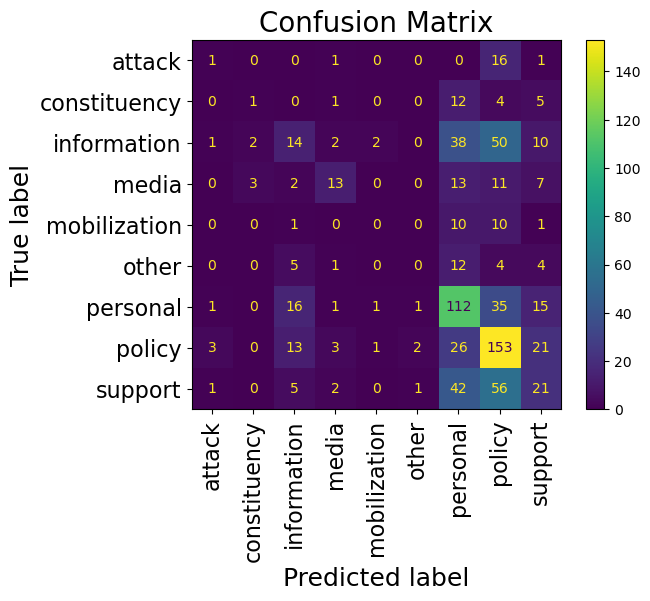

In [13]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train_message)

# %%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test_message))
print(classification_report(y_test_message, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

accuracy 0.3468354430379747
              precision    recall  f1-score   support

      attack       0.09      0.05      0.07        19
constituency       0.17      0.04      0.07        23
 information       0.20      0.14      0.17       119
       media       0.47      0.18      0.26        49
mobilization       0.20      0.05      0.07        22
       other       0.20      0.04      0.06        26
    personal       0.42      0.53      0.47       182
      policy       0.44      0.51      0.47       222
     support       0.20      0.27      0.23       128

    accuracy                           0.35       790
   macro avg       0.27      0.20      0.21       790
weighted avg       0.33      0.35      0.33       790



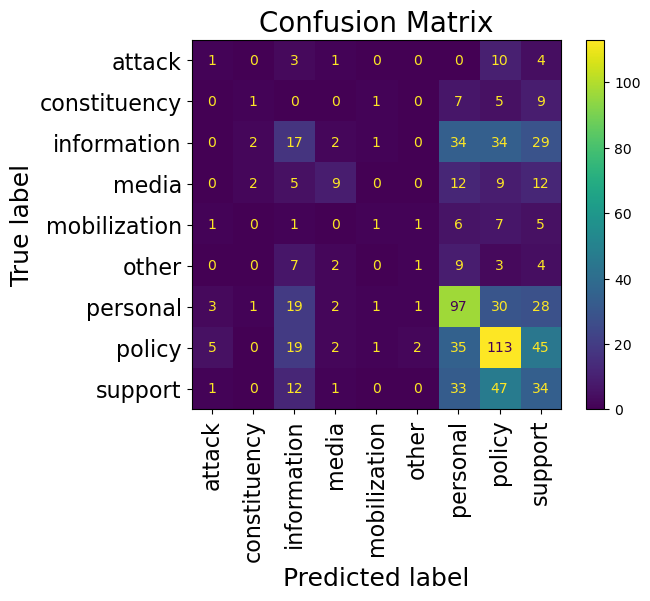

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)),
               ])
logreg.fit(X_train, y_train_message)

# %%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test_message))
print(classification_report(y_test_message, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

In [55]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df_poli = pd.read_csv('data/political_tweets.csv')
df_poli = df_poli[df_poli['Party'] != 'I']
print(df_poli.head(10))

   Unnamed: 0      bias      message  \
0           1  partisan       attack   
1           2   neutral      support   
2           3   neutral       policy   
3           4  partisan       policy   
4           5  partisan  information   
5           8   neutral     personal   
6           9  partisan      support   
7          10  partisan       policy   
8          11  partisan       attack   
9          12   neutral       policy   

                                               label  \
0      From: Mitch McConnell (Senator from Kentucky)   
1   From: Kurt Schrader (Representative from Oregon)   
2           From: Michael Crapo (Senator from Idaho)   
3           From: Mark Udall (Senator from Colorado)   
4   From: Heidi Heitkamp (Senator from North Dakota)   
5  From: Chuck Fleischmann (Representative from T...   
6   From: Steny Hoyer (Representative from Maryland)   
7  From: John Fleming (Representative from Louisi...   
8  From: Adam Kinzinger (Representative from Illi...   

from nltk.corpus import stopwords

replace_w_space = re.compile('[/(){}\[\]\|,;]@#')#I took out # symbol below (allowed) and put it here. ,......but maybe I should add it back
bad_symbols_re = re.compile('[^0-9a-z +_]')
stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = replace_w_space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = bad_symbols_re.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwors from text
    return text
    
df_poli['text'] = df_poli['text'].apply(clean_text)
df_poli['text'].head(20)

In [61]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet



nltk.download('punkt')


# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return tweet_norm

df_poli['text'] = df_poli['text'].apply(process_tweet, args = [3])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/forrestwilliams/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

/var/folders/bf/n_rprvk91ndgxz_bd75lz03h0000gp/T/ipykernel_16745/2833187167.py:3: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  wv.init_sims(replace=True)


In [62]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [63]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df_poli, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

accuracy 0.613481228668942
              precision    recall  f1-score   support

           D       0.54      0.51      0.52       493
           R       0.66      0.69      0.67       679

    accuracy                           0.61      1172
   macro avg       0.60      0.60      0.60      1172
weighted avg       0.61      0.61      0.61      1172



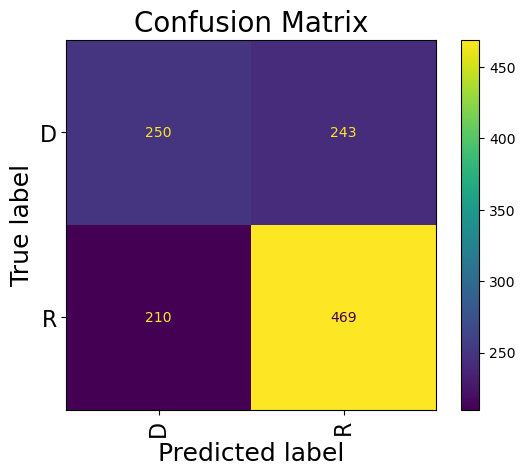

In [64]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg = logreg.fit(X_train_word_average, train['Party'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()

accuracy 0.5714285714285714
              precision    recall  f1-score   support

           D       0.51      0.57      0.54       406
           I       0.36      0.56      0.43         9
           R       0.64      0.57      0.60       530

    accuracy                           0.57       945
   macro avg       0.50      0.57      0.53       945
weighted avg       0.58      0.57      0.57       945



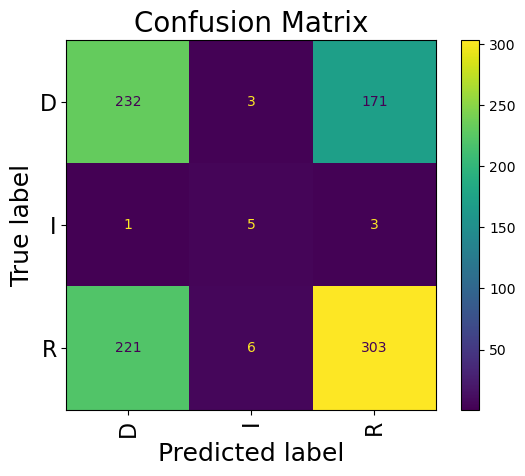

In [99]:
from sklearn.naive_bayes import GaussianNB

GNB_clf = GaussianNB()
GNB_clf = GNB_clf.fit(X_train_word_average, train['Party'])
y_pred = GNB_clf.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()





accuracy 0.6042328042328042
              precision    recall  f1-score   support

           D       0.55      0.45      0.50       406
           I       1.00      0.11      0.20         9
           R       0.63      0.73      0.68       530

    accuracy                           0.60       945
   macro avg       0.73      0.43      0.46       945
weighted avg       0.60      0.60      0.59       945



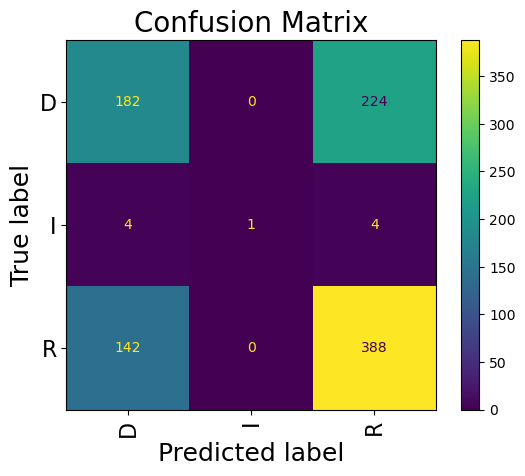

In [100]:
from sklearn.svm import LinearSVC

SVC_clf = LinearSVC()
SVC_clf = SVC_clf.fit(X_train_word_average, train['Party'])
y_pred = SVC_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()



accuracy 0.5068783068783069
              precision    recall  f1-score   support

           D       0.44      0.44      0.44       406
           I       0.08      0.11      0.10         9
           R       0.57      0.57      0.57       530

    accuracy                           0.51       945
   macro avg       0.36      0.37      0.37       945
weighted avg       0.51      0.51      0.51       945



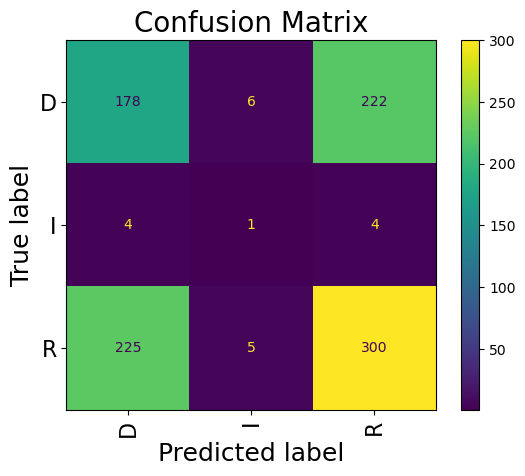

In [101]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf = DT_clf.fit(X_train_word_average, train['Party'])
y_pred = DT_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()



accuracy 0.5883597883597883
              precision    recall  f1-score   support

           D       0.58      0.23      0.33       406
           I       0.00      0.00      0.00         9
           R       0.59      0.87      0.70       530

    accuracy                           0.59       945
   macro avg       0.39      0.37      0.34       945
weighted avg       0.58      0.59      0.54       945



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

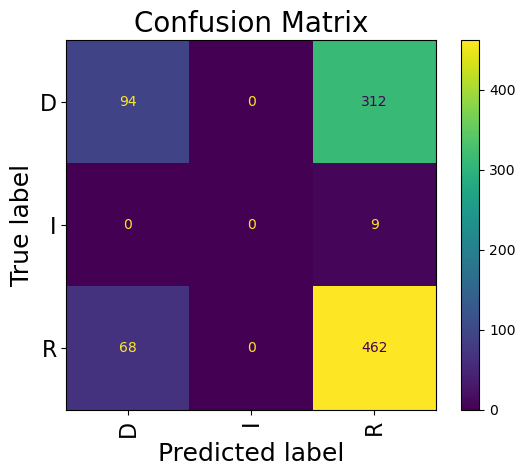

In [102]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier()
RF_clf = RF_clf.fit(X_train_word_average, train['Party'])
y_pred = RF_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()


accuracy 0.5894179894179894
              precision    recall  f1-score   support

           D       0.54      0.47      0.50       406
           I       1.00      0.11      0.20         9
           R       0.62      0.69      0.65       530

    accuracy                           0.59       945
   macro avg       0.72      0.42      0.45       945
weighted avg       0.59      0.59      0.58       945



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


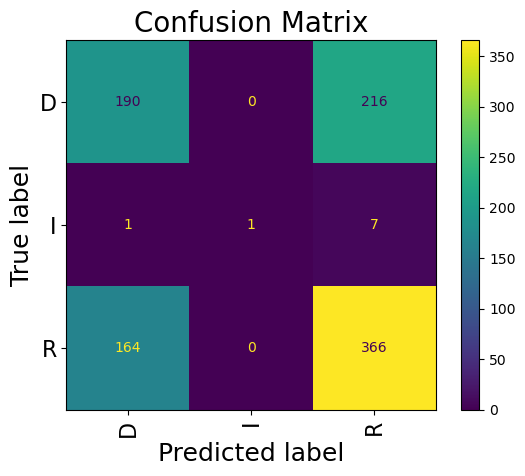

In [104]:
from sklearn.neural_network import MLPClassifier

Best_NN_clf = MLPClassifier()
Best_NN_clf = NN_clf.fit(X_train_word_average, train['Party'])
y_pred = NN_clf.predict(X_test_word_average)


print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()




In [105]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

df_poli = pd.read_csv('data/political_tweets.csv')
df_poli = df_poli[df_poli['Party'] != 'I']
print(df_poli.head(10))

   Unnamed: 0      bias      message  \
0           1  partisan       attack   
1           2   neutral      support   
2           3   neutral       policy   
3           4  partisan       policy   
4           5  partisan  information   
5           8   neutral     personal   
6           9  partisan      support   
7          10  partisan       policy   
8          11  partisan       attack   
9          12   neutral       policy   

                                               label  \
0      From: Mitch McConnell (Senator from Kentucky)   
1   From: Kurt Schrader (Representative from Oregon)   
2           From: Michael Crapo (Senator from Idaho)   
3           From: Mark Udall (Senator from Colorado)   
4   From: Heidi Heitkamp (Senator from North Dakota)   
5  From: Chuck Fleischmann (Representative from T...   
6   From: Steny Hoyer (Representative from Maryland)   
7  From: John Fleming (Representative from Louisi...   
8  From: Adam Kinzinger (Representative from Illi...   

In [106]:
from nltk.corpus import stopwords

replace_w_space = re.compile('[/(){}\[\]\|,;]@#')#I took out # symbol below (allowed) and put it here. ,......but maybe I should add it back
bad_symbols_re = re.compile('[^0-9a-z +_]')
stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = replace_w_space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = bad_symbols_re.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwors from text
    return text
    
df_poli['text'] = df_poli['text'].apply(clean_text)
df_poli['text'].head(20)

0     video obamacare full higher costs broken promi...
1     please join today remembering fallen heroes ho...
2     rt senatorleahy 1st step toward senate debate ...
3     amazon delivery drones show need update law pr...
4     called usdotfra release info inspections casse...
5     wonderful night state senator ken yagers chili...
6     great oped pres clinton signing fmla 20 yrs ag...
7     potus golfs pushes amnesty amp ignores keyston...
8     president doesnt get decide doesnt like congre...
9     fact recovery act cut taxes middleclass famili...
10    rt mha telemedicine consults rural ers helps p...
11              skitchp wouldnt wish anyone even skitch
12    545pm sen corybooker give maiden senate speech...
13    come liberation bound mine let us work togethe...
14    health coverage starting jan 1st must sign acc...
15    tks margaret 4 joining dc share successes nisk...
16    great look back idaho native american tribes 1...
17    otd 1969 american astronaut neil armstrong

In [107]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [108]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df_poli, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

# BEST PARTY CLASSIFIER (Best_NN_clf)

accuracy 0.6373720136518771
              precision    recall  f1-score   support

           D       0.58      0.53      0.55       493
           R       0.68      0.72      0.70       679

    accuracy                           0.64      1172
   macro avg       0.63      0.62      0.62      1172
weighted avg       0.63      0.64      0.63      1172



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


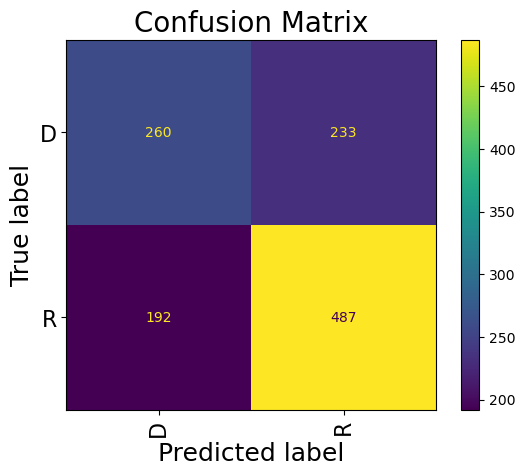

In [110]:
from sklearn.neural_network import MLPClassifier

Best_NN_clf = MLPClassifier()
Best_NN_clf = NN_clf.fit(X_train_word_average, train['Party'])
y_pred = NN_clf.predict(X_test_word_average)


print('accuracy %s' % accuracy_score(y_pred, test.Party))
print(classification_report(test.Party, y_pred))
ConfusionMatrixDisplay.from_predictions(test.Party, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()


# GRID SEARCH ^^^^

(Also, try boosted)

# BEST MESSAGE PREDICTOR (GNB_clf_message)

accuracy 0.36689419795221845
              precision    recall  f1-score   support

      attack       0.18      0.48      0.26        44
constituency       0.06      0.27      0.10        26
 information       0.36      0.23      0.28       157
       media       0.35      0.56      0.43        70
mobilization       0.14      0.10      0.12        29
       other       0.00      0.00      0.00        27
    personal       0.48      0.44      0.46       287
      policy       0.48      0.55      0.51       301
     support       0.33      0.13      0.19       231

    accuracy                           0.37      1172
   macro avg       0.26      0.31      0.26      1172
weighted avg       0.39      0.37      0.36      1172



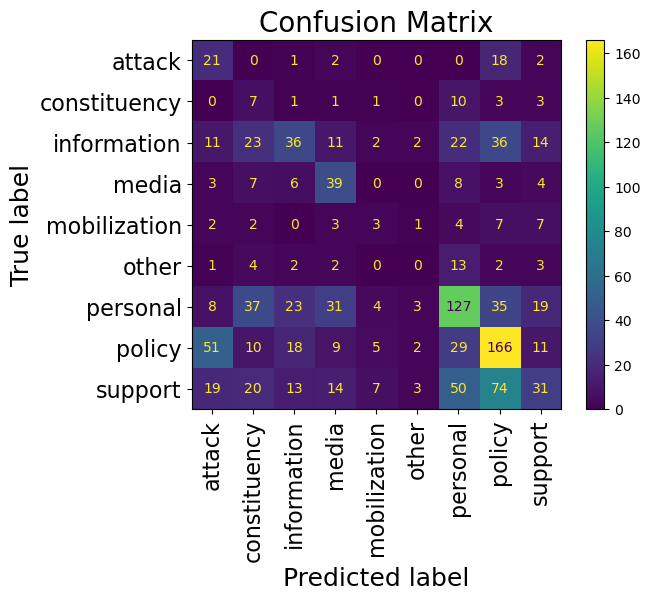

In [112]:
from sklearn.naive_bayes import GaussianNB

GNB_clf_message = GaussianNB()
GNB_clf_message = GNB_clf.fit(X_train_word_average, train['message'])
y_pred = GNB_clf.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()





accuracy 0.41469594594594594
              precision    recall  f1-score   support

      attack       0.07      0.03      0.04        34
constituency       0.33      0.03      0.06        32
 information       0.42      0.15      0.23       176
       media       0.54      0.39      0.45        67
mobilization       1.00      0.06      0.11        34
       other       0.00      0.00      0.00        34
    personal       0.42      0.66      0.51       280
      policy       0.45      0.67      0.54       334
     support       0.22      0.13      0.16       193

    accuracy                           0.41      1184
   macro avg       0.38      0.24      0.23      1184
weighted avg       0.40      0.41      0.36      1184



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

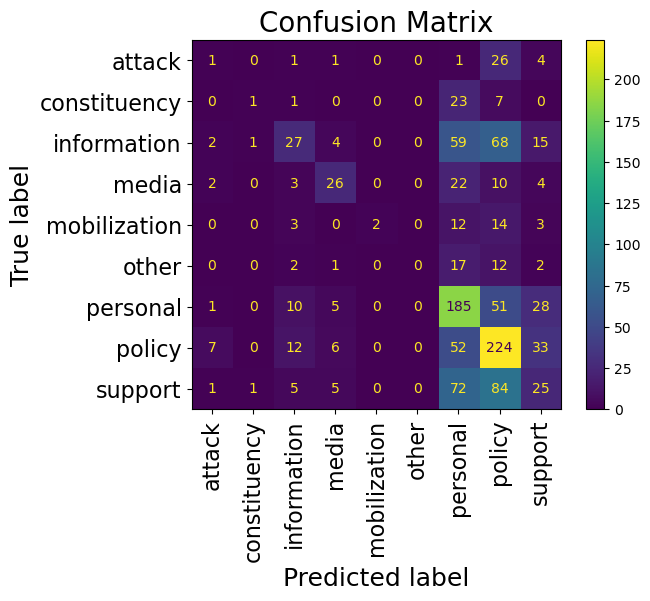

In [36]:
from sklearn.svm import LinearSVC

SVC_clf = LinearSVC()
SVC_clf = SVC_clf.fit(X_train_word_average, train['message'])
y_pred = SVC_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()





accuracy 0.41469594594594594
              precision    recall  f1-score   support

      attack       0.07      0.03      0.04        34
constituency       0.33      0.03      0.06        32
 information       0.42      0.15      0.23       176
       media       0.54      0.39      0.45        67
mobilization       1.00      0.06      0.11        34
       other       0.00      0.00      0.00        34
    personal       0.42      0.66      0.51       280
      policy       0.45      0.67      0.54       334
     support       0.22      0.13      0.16       193

    accuracy                           0.41      1184
   macro avg       0.38      0.24      0.23      1184
weighted avg       0.40      0.41      0.36      1184



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

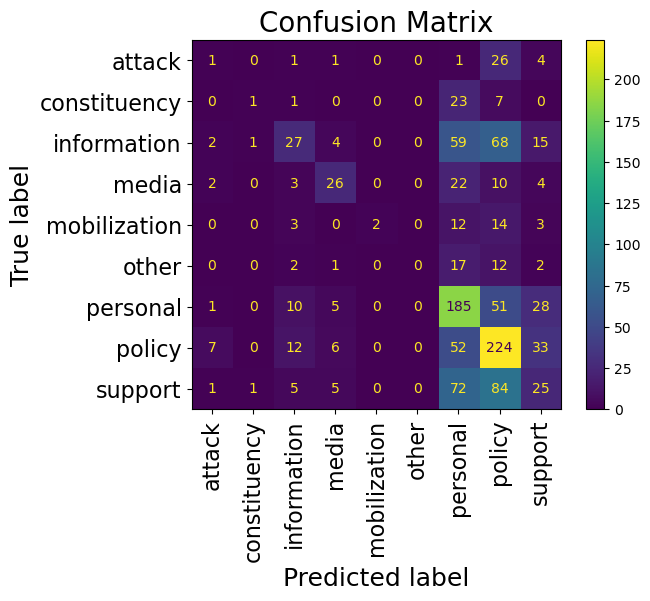

In [37]:
from sklearn.svm import LinearSVC

SVC_clf = LinearSVC()
SVC_clf = SVC_clf.fit(X_train_word_average, train['message'])
y_pred = SVC_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()




accuracy 0.23902027027027026
              precision    recall  f1-score   support

      attack       0.05      0.09      0.06        34
constituency       0.02      0.03      0.03        32
 information       0.15      0.14      0.14       176
       media       0.13      0.10      0.12        67
mobilization       0.04      0.03      0.03        34
       other       0.05      0.03      0.04        34
    personal       0.34      0.35      0.35       280
      policy       0.35      0.31      0.33       334
     support       0.18      0.21      0.20       193

    accuracy                           0.24      1184
   macro avg       0.15      0.15      0.14      1184
weighted avg       0.24      0.24      0.24      1184



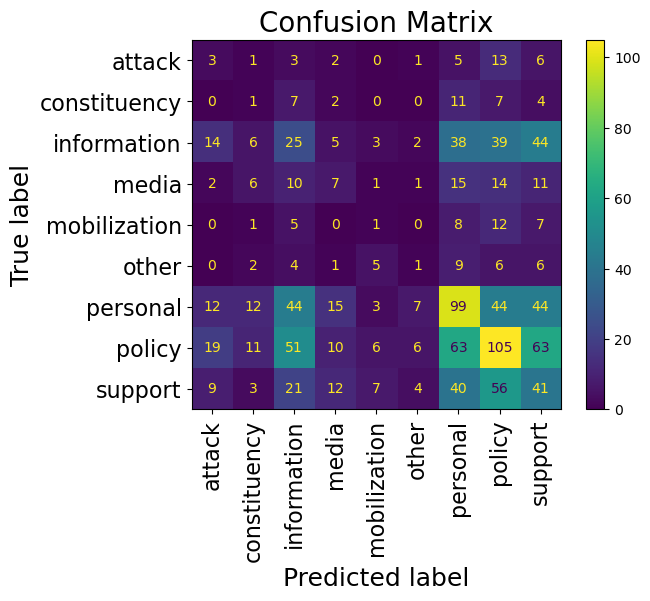

In [38]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf = DT_clf.fit(X_train_word_average, train['message'])
y_pred = DT_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()




/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy 0.30802047781569963
              precision    recall  f1-score   support

      attack       0.14      0.11      0.13        44
constituency       0.12      0.15      0.14        26
 information       0.19      0.17      0.18       157
       media       0.33      0.23      0.27        70
mobilization       0.10      0.07      0.08        29
       other       0.00      0.00      0.00        27
    personal       0.40      0.43      0.42       287
      policy       0.37      0.46      0.41       301
     support       0.23      0.19      0.21       231

    accuracy                           0.31      1172
   macro avg       0.21      0.20      0.20      1172
weighted avg       0.30      0.31      0.30      1172



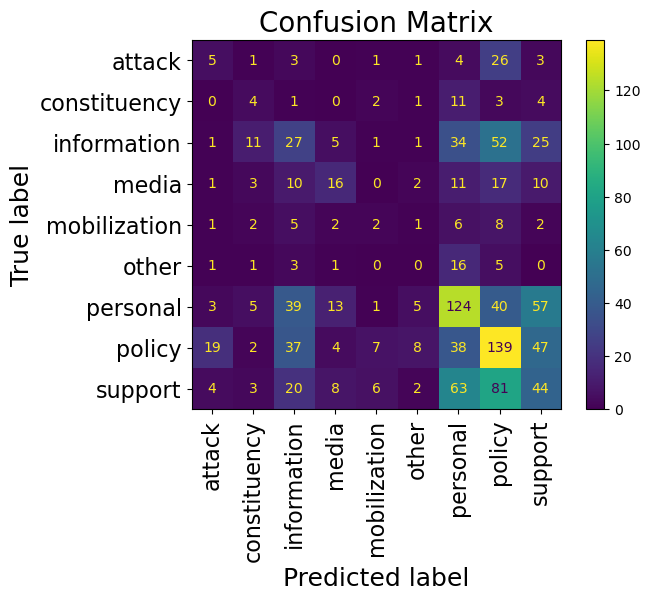

In [113]:
from sklearn.neural_network import MLPClassifier

NN_clf = MLPClassifier()
NN_clf = NN_clf.fit(X_train_word_average, train['message'])
y_pred = NN_clf.predict(X_test_word_average)


print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()




accuracy 0.3984641638225256
              precision    recall  f1-score   support

      attack       0.00      0.00      0.00        44
constituency       0.00      0.00      0.00        26
 information       0.33      0.02      0.04       157
       media       0.41      0.10      0.16        70
mobilization       0.00      0.00      0.00        29
       other       0.00      0.00      0.00        27
    personal       0.41      0.72      0.52       287
      policy       0.39      0.80      0.53       301
     support       0.30      0.03      0.06       231

    accuracy                           0.40      1172
   macro avg       0.21      0.19      0.15      1172
weighted avg       0.33      0.40      0.29      1172



/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/forrestwilliams/anaconda3/envs/wheelydope/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

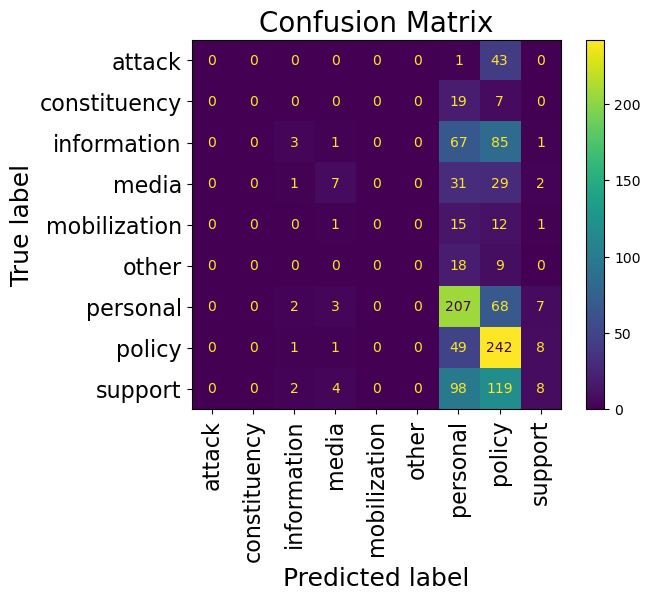

In [114]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_estimators=200)
RF_clf = RF_clf.fit(X_train_word_average, train['message'])
y_pred = RF_clf.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, test.message))
print(classification_report(test.message, y_pred))
ConfusionMatrixDisplay.from_predictions(test.message, y_pred)
plt.xticks(rotation=90)  # rotate x-axis labels
plt.yticks(fontsize=16) # increase y-axis font size
plt.xticks(fontsize=16) # increase x-axis font size
plt.xlabel('Predicted label', fontsize=18) # increase x label font size
plt.ylabel('True label', fontsize=18) # increase y label font size
plt.title('Confusion Matrix', fontsize=20) # increase title font size
plt.show()


# Feed the machine with MGP and Deluzio. Do it for message and bias

In [ ]:
# BEST PARTY CLASSIFIER (Best_NN_clf)
# BEST MESSAGE PREDICTOR (GNB_clf_message)
# Best GNB (Best_GNB_Bias)

In [116]:
MGP_tweets = pd.read_csv('data/mgp_full_tweets.csv')

In [117]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [121]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
MGP_tweets_tokenized = MGP_tweets.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
MGP_tweets_word_average = word_averaging_list(wv, MGP_tweets_tokenized)



In [130]:
# Predict the labels of the new tweets
MGP_tweets_predictions_message = GNB_clf_message.predict(MGP_tweets_word_average)

MGP_tweets_predictions_message_Series = pd.Series(MGP_tweets_predictions_message)

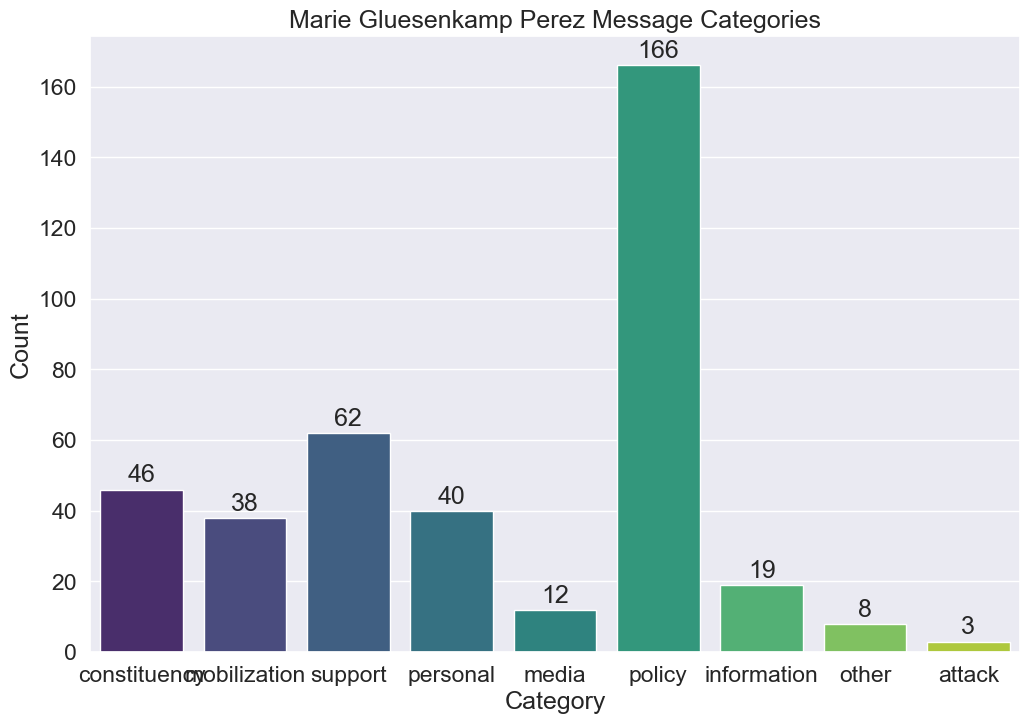

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set_style("whitegrid")

# Increase default font size
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=MGP_tweets_predictions_message_Series, palette="viridis")
plt.title('Marie Gluesenkamp Perez Message Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


In [136]:
# Predict the labels of the new tweets
MGP_tweets_predictions_party = Best_NN_clf.predict(MGP_tweets_word_average)
MGP_tweets_predictions_party_Series = pd.Series(MGP_tweets_predictions_bias)

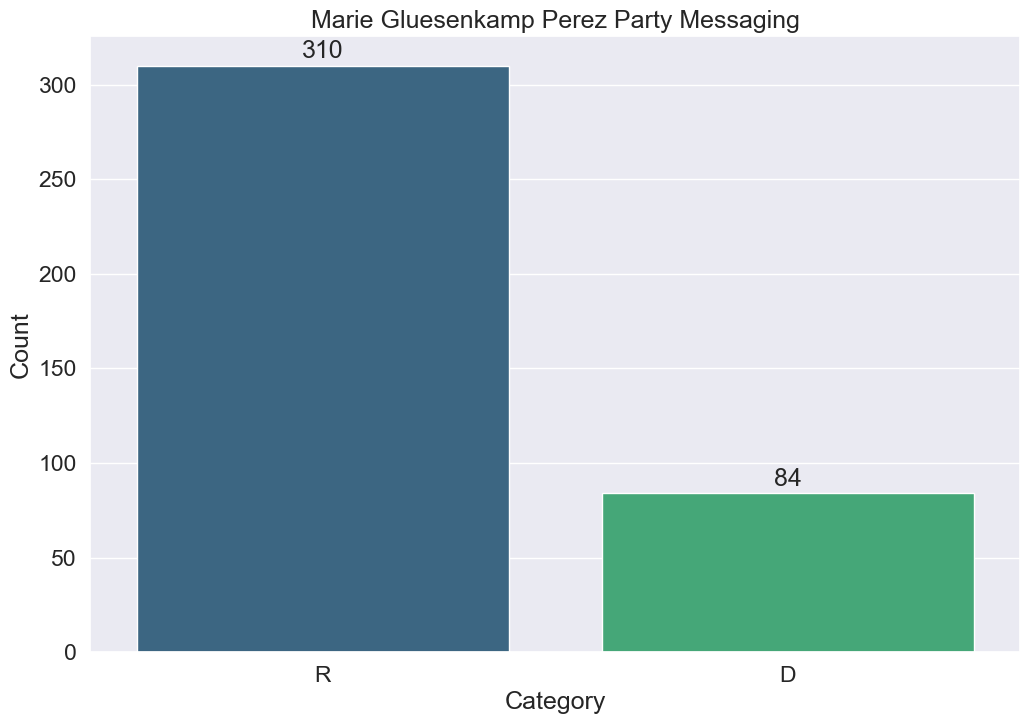

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=MGP_tweets_predictions_party_Series, palette="viridis")
plt.title('Marie Gluesenkamp Perez Party Messaging')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


In [140]:
# Best_GNB_Bias
# Predict the labels of the new tweets
MGP_tweets_predictions_bias = Best_GNB_bias.predict(MGP_tweets_word_average)
MGP_tweets_predictions_bias_Series = pd.Series(MGP_tweets_predictions_bias)

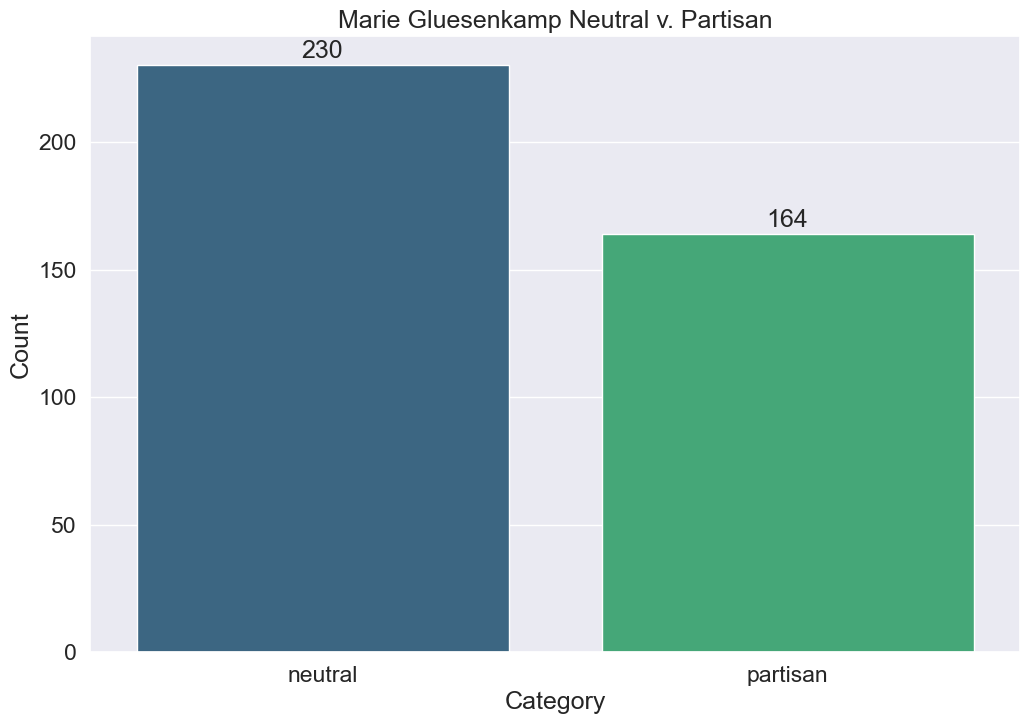

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=MGP_tweets_predictions_bias_Series, palette="viridis")
plt.title('Marie Gluesenkamp Neutral v. Partisan')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


# DELOZIO

In [142]:
Delozio_tweets = pd.read_csv('data/Delozio_Tweets.csv')

In [143]:
# BEST PARTY CLASSIFIER (Best_NN_clf)
# BEST MESSAGE PREDICTOR (GNB_clf_message)
# Best GNB (Best_GNB_Bias)

In [144]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.get_vector(word))
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [145]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
Delozio_tweets_tokenized = Delozio_tweets.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
Delozio_tweets_word_average = word_averaging_list(wv, Delozio_tweets_tokenized)



In [146]:
# Predict the labels of the new tweets
Delozio_tweets_predictions_message = GNB_clf_message.predict(Delozio_tweets_word_average)

Delozio_tweets_predictions_message_Series = pd.Series(Delozio_tweets_predictions_message)

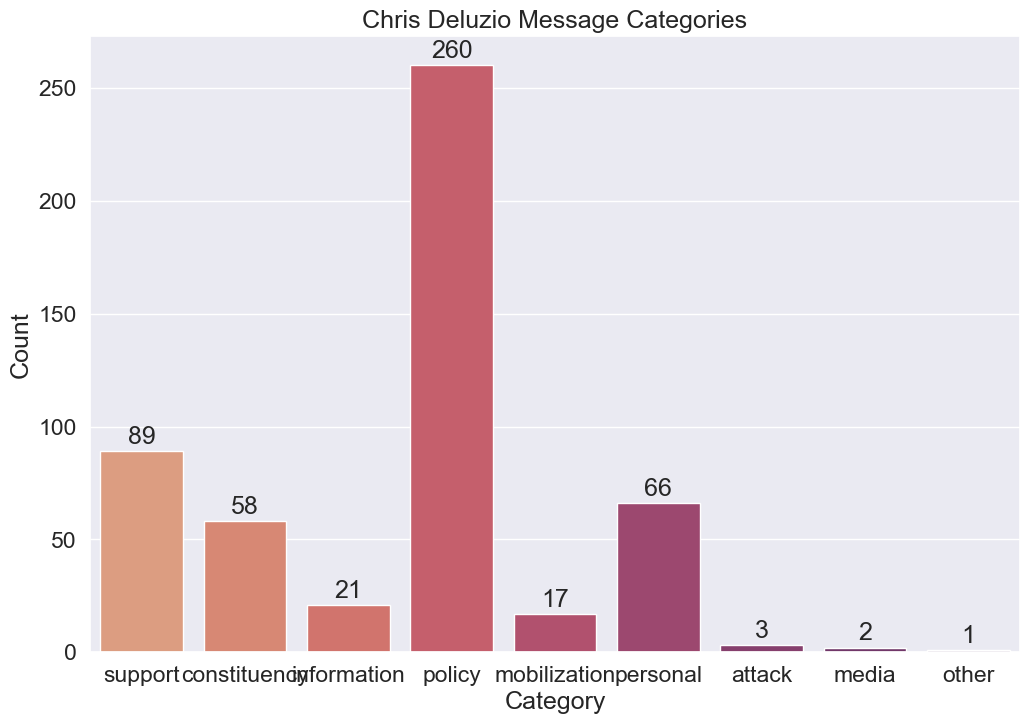

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set_style("whitegrid")

# Increase default font size
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=Delozio_tweets_predictions_message_Series, palette="flare")
plt.title('Chris Deluzio Message Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


In [156]:
# Predict the labels of the new tweets
Delozio_tweets_predictions_party = Best_NN_clf.predict(Delozio_tweets_word_average)
Delozio_tweets_predictions_party_Series = pd.Series(Delozio_tweets_predictions_party)

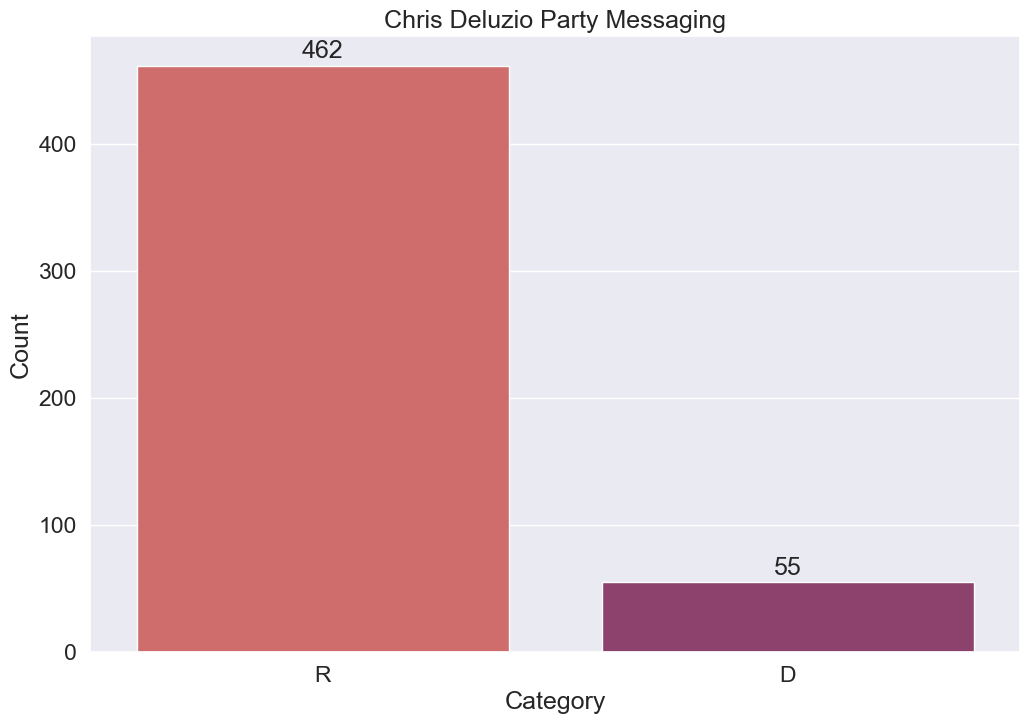

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=Delozio_tweets_predictions_party_Series, palette="flare")
plt.title('Chris Deluzio Party Messaging')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


In [159]:
# Best_GNB_Bias
# Predict the labels of the new tweets
Delozio_tweets_predictions_bias = Best_GNB_bias.predict(Delozio_tweets_word_average)
Delozio_tweets_predictions_bias_Series = pd.Series(Delozio_tweets_predictions_bias)

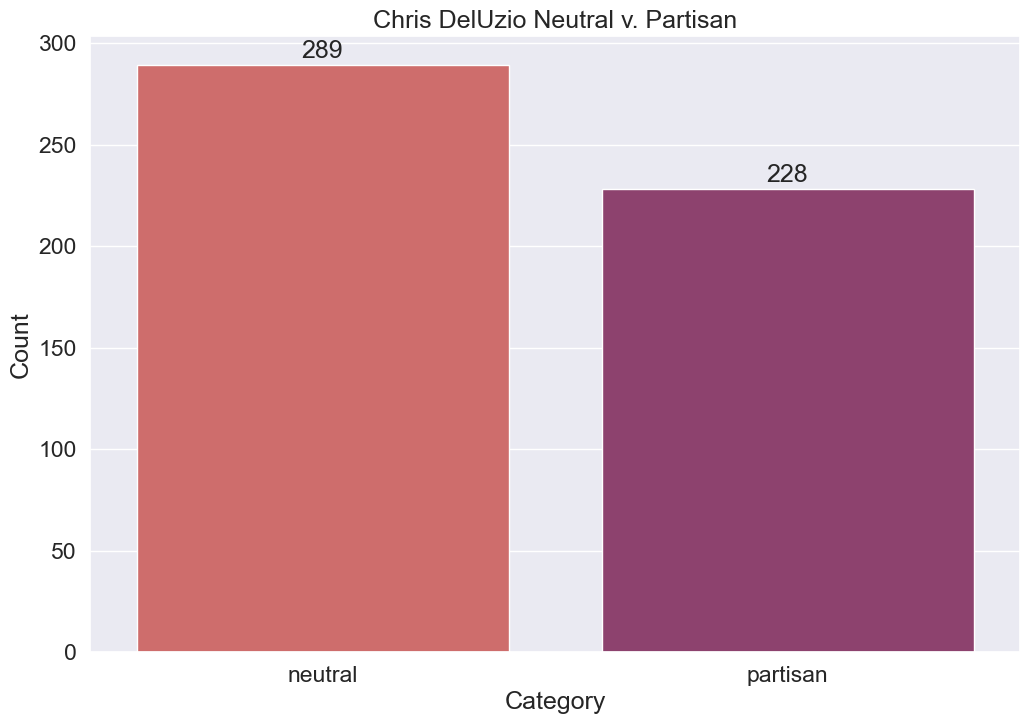

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Generate the plot
plt.figure(figsize=(12, 8))  # Increase the size
ax = sns.countplot(x=Delozio_tweets_predictions_bias_Series, palette="flare")
plt.title('Chris DelUzio Neutral v. Partisan')
plt.xlabel('Category')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


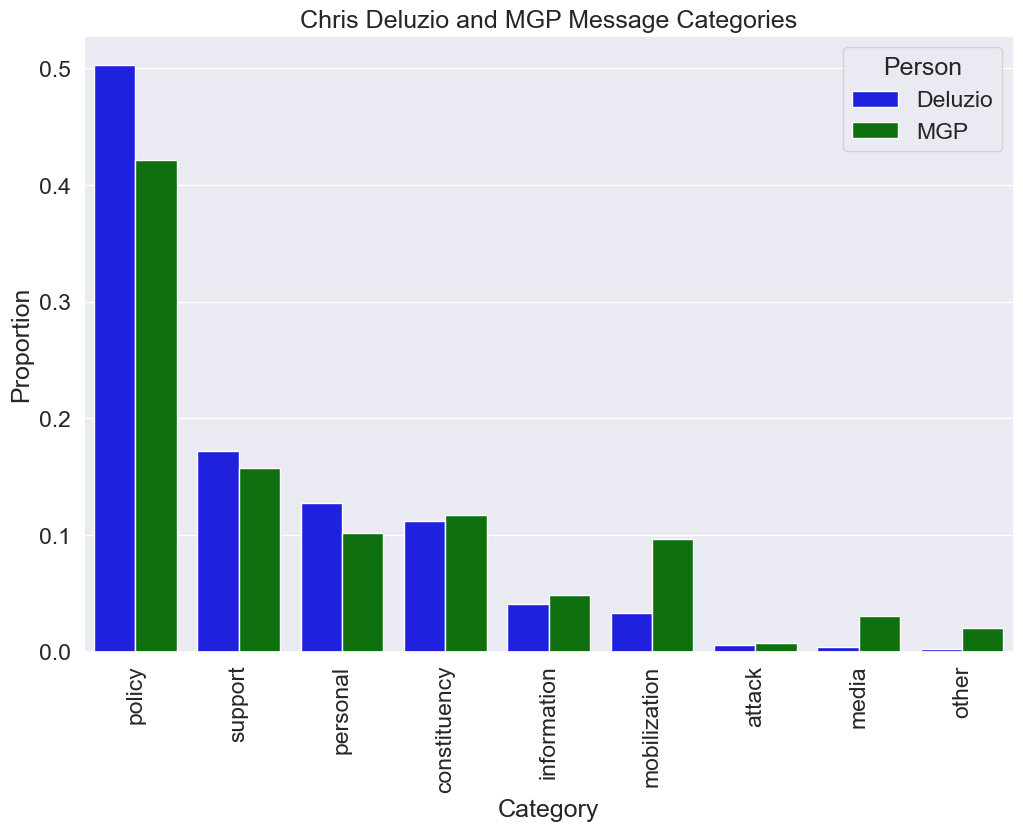

In [165]:
# Imbalanced Tweetset, so making proportional to each other
df_delozio = Delozio_tweets_predictions_message_Series.value_counts(normalize=True).reset_index()
df_delozio.columns = ['Category', 'Proportion']
df_delozio['Person'] = 'Deluzio'

df_mgp = MGP_tweets_predictions_message_Series.value_counts(normalize=True).reset_index()
df_mgp.columns = ['Category', 'Proportion']
df_mgp['Person'] = 'MGP'

# Combine dataframes
df_combined = pd.concat([df_delozio, df_mgp])

# plot
plt.figure(figsize=(12, 8))  
ax = sns.barplot(data=df_combined, x='Category', y='Proportion', hue='Person', 
                 palette=['blue', 'green'])

plt.title('Chris Deluzio and MGP Message Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.show()


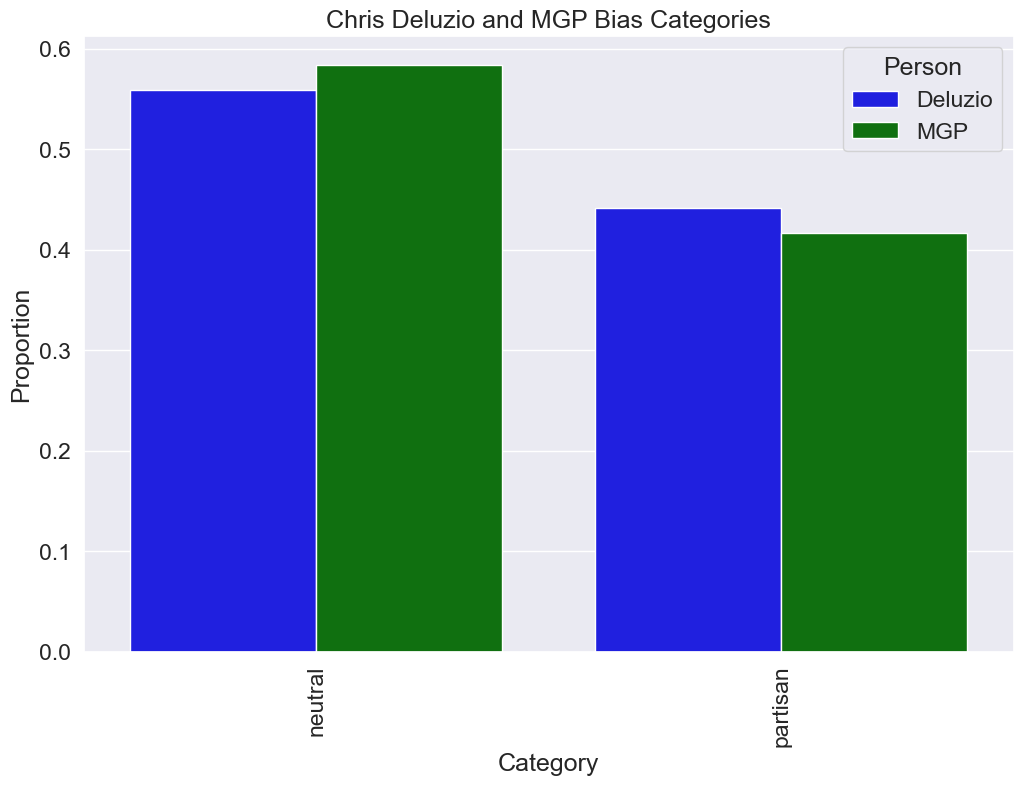

In [164]:
import pandas as pd

# making proportional
df_delozio = Delozio_tweets_predictions_bias_Series.value_counts(normalize=True).reset_index()
df_delozio.columns = ['Category', 'Proportion']
df_delozio['Person'] = 'Deluzio'

df_mgp = MGP_tweets_predictions_bias_Series.value_counts(normalize=True).reset_index()
df_mgp.columns = ['Category', 'Proportion']
df_mgp['Person'] = 'MGP'

# combine dataframes
df_combined = pd.concat([df_delozio, df_mgp])

# plot
plt.figure(figsize=(12, 8))  
ax = sns.barplot(data=df_combined, x='Category', y='Proportion', hue='Person', 
                 palette=['blue', 'green'])

plt.title('Chris Deluzio and MGP Bias Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.show()


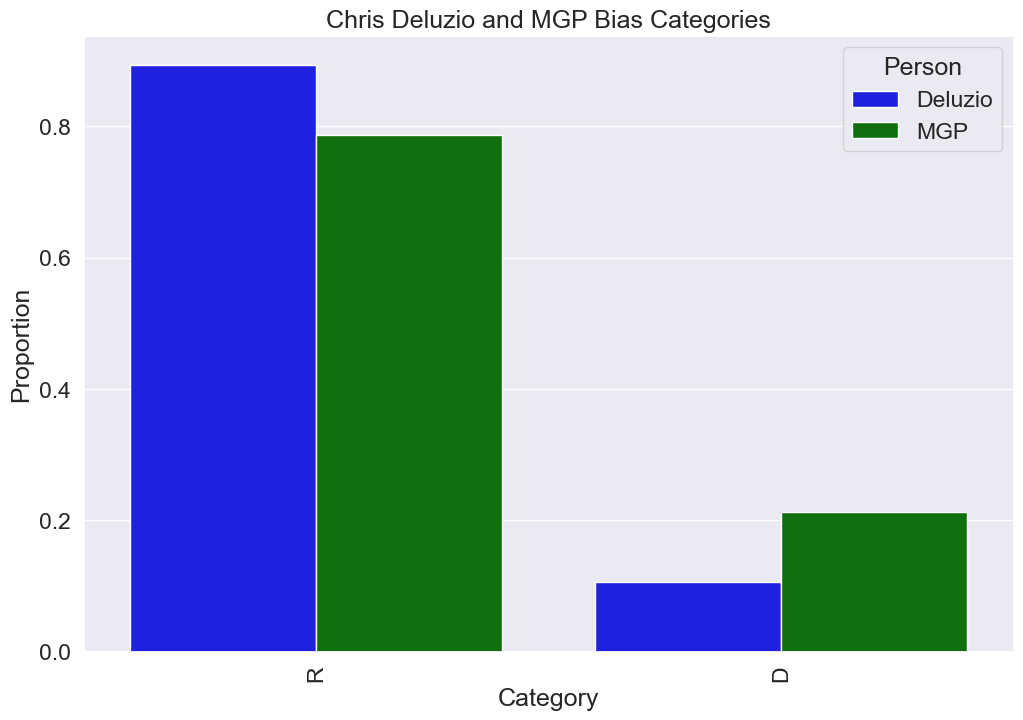

In [166]:
import pandas as pd

# making proportional
df_delozio = Delozio_tweets_predictions_party_Series.value_counts(normalize=True).reset_index()
df_delozio.columns = ['Category', 'Proportion']
df_delozio['Person'] = 'Deluzio'

df_mgp = MGP_tweets_predictions_party_Series.value_counts(normalize=True).reset_index()
df_mgp.columns = ['Category', 'Proportion']
df_mgp['Person'] = 'MGP'

# combine dataframes
df_combined = pd.concat([df_delozio, df_mgp])

# plot
plt.figure(figsize=(12, 8))  
ax = sns.barplot(data=df_combined, x='Category', y='Proportion', hue='Person', 
                 palette=['blue', 'green'])

plt.title('Chris Deluzio and MGP Bias Categories')
plt.xlabel('Category')
plt.ylabel('Proportion')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.show()


## Unsupervised learning on their tweets after pre-processing

In [167]:
import pandas as pd

data = {
    "DISTRICT": ["AK-AL", "ME-02", "NH-01", "MD-06", "MI-07", "CO-03", "PA-08", "PA-17", "OH-13", "WA-08", "WA-03", "NC-13", "MN-02", "PA-07", "OH-01", "VA-07", "MT-01", "MI-10"],
    "FIRST": ["Mary", "Jared", "Chris", "David", "Elissa", "Lauren", "Matt", "Chris", "Emilia", "Kim", "Marie Gluesenkamp", "Wiley", "Angie", "Susan", "Greg", "Abigail", "Ryan", "John"],
    "LAST": ["Peltola", "Golden", "Pappas", "Trone", "Slotkin", "Boebert", "Cartwright", "Deluzio", "Sykes", "Schrier", "Perez", "Nickel", "Craig", "Wild", "Landsman", "Spanberger", "Zinke", "James"],
    "PVI": [-8.02, -5.57, 0.06, 1.97, -2.12, -7.06, -4.12, 0.37, -0.64, 1.05, -4.62, -1.64, 0.61, -2.12, 1.75, 0.88, -6.23, -3.05],
    "PERFORMANCE": [18.02, 11.77, 8.04, 7.53, 7.52, 6.86, 6.52, 6.43, 6.04, 5.85, 5.42, 4.84, 4.69, 4.12, 3.85, 3.72, 3.13, 2.55],
    "FINAL MARGIN": [10.0, 6.2, 8.1, 9.5, 5.4, -0.2, 2.4, 6.8, 5.4, 6.9, 0.8, 3.2, 5.3, 2.0, 5.6, 4.6, -3.1, -0.5]
}

df = pd.DataFrame(data)


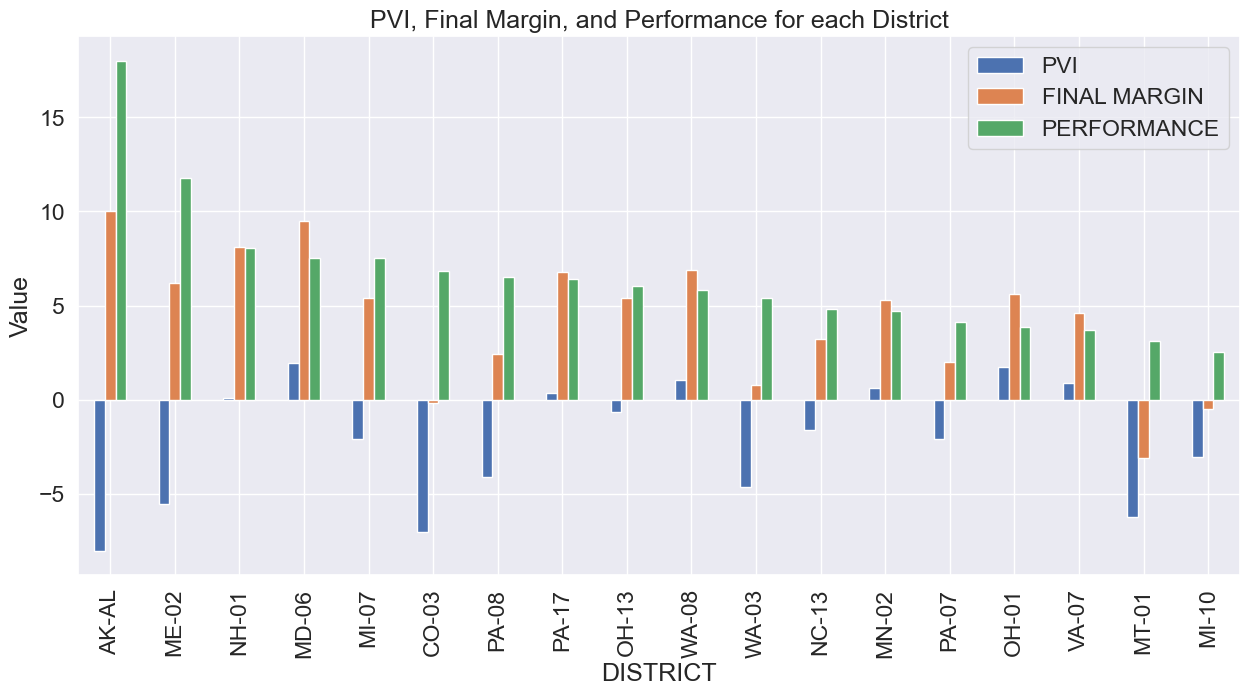

In [168]:
import matplotlib.pyplot as plt

# Setting DISTRICT column as the index 
df.set_index("DISTRICT", inplace=True)

# Plot
df[["PVI", "FINAL MARGIN", "PERFORMANCE"]].plot(kind='bar', figsize=(15, 7))

plt.ylabel('Value')
plt.title('PVI, Final Margin, and Performance for each District')
plt.grid(True)
plt.show()


## Cosine similarity of topic tweets with others.. tweets or a corpus?

## Cosine similarity of their districts with each other

## tinker tailor soldier spy -- set up 

## level-up: hate speech